# Emissions de polluants dans l'air 

In [1]:
import sys
sys.path.append('../../')
import re
from config.settings import settings
from slugify import slugify

import dtale as dt
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
DATASETS_BASE = settings.MODULES_TO_DATASETS_PATH

## Récupération des datasets

### F5-1 ENERGY

In [66]:
df_f5_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_ENERGY_F5_1, low_memory=False)
df_f5_1.head()

countryName  reportingYear typefeature      feature unit  featureValue
0     Austria           2016        fuel      Biomass   TJ       8903.96
1     Austria           2016        fuel         Coal   TJ          0.00
2     Austria           2016        fuel      Lignite   TJ          0.00
3     Austria           2016        fuel  LiquidFuels   TJ      14558.74
4     Austria           2016        fuel   NaturalGas   TJ      83034.06

### F5-2 ENERGY

In [67]:
df_f5_2 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_ENERGY_F5_2, low_memory=False)
df_f5_2.head()

countryName  reportingYear                LCPInspireID installationPartName   
0     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3  \
1     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
2     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
3     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
4     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   

  installationPartNameConfidentialityReason  Longitude   Latitude   
0                                       NaN  14.256111  48.183056  \
1                                       NaN  14.256111  48.183056   
2                                       NaN  14.256111  48.183056   
3                                       NaN  14.256111  48.183056   
4                                       NaN  14.256111  48.183056   

  addressConfidentialityReason featureType      feature unit  featureValue   
0                          NaN        fuel      Biomass   TJ          0.00  \
1                          NaN        fuel         Coal   TJ          0.00   
2                          NaN        fuel      Lignite   TJ          0.00   
3                          NaN        fuel  LiquidFuels   TJ         15.63   
4                          NaN        fuel   NaturalGas   TJ          0.00   

   ConfidentialityReason  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

### F6-1 INFORMATION

In [68]:
df_f6_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_INFORMATION_F6_1, low_memory=False)
df_f6_1.head()

countryName  reportingYear               InstallationInspireID   
0     Austria           2017  AT.CAED/9008390374726.INSTALLATION  \
1     Austria           2017  AT.CAED/9008390374726.INSTALLATION   
2     Austria           2017  AT.CAED/9008390374726.INSTALLATION   
3     Austria           2018  AT.CAED/9008390374726.INSTALLATION   
4     Austria           2018  AT.CAED/9008390374726.INSTALLATION   

   installationName installationNameConfidentialityReason  Longitude   
0               NaN                                   NaN  13.691667  \
1               NaN                                   NaN  13.691667   
2               NaN                                   NaN  13.691667   
3               NaN                                   NaN  13.691667   
4               NaN                                   NaN  13.691667   

    Latitude addressConfidentialityReason CityofFacility IEDActivityCode  ...   
0  46.556667                          NaN    Arnoldstein          5.2(a)  ...  \
1  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
2  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
3  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
4  46.556667                          NaN    Arnoldstein          5.2(a)  ...   

  siteVisitNumber  relevantChapter dateOfGranting  permitGranted   
0             0.0              NaN     20111013.0            Yes  \
1             0.0              NaN     20111013.0            Yes   
2             0.0              NaN     20111013.0            Yes   
3             0.0              NaN     20111013.0            Yes   
4             0.0              NaN     20111013.0            Yes   

  permitReconsidered permitUpdated dateOfLastUpdate  permitURL    featureType   
0                Yes            No              NaN        NaN         BATAEL  \
1                Yes            No              NaN        NaN  BATConclusion   
2                Yes            No              NaN        NaN  BATDerogation   
3                Yes            No              NaN        NaN         BATAEL   
4                Yes            No              NaN        NaN  BATConclusion   

  featureValue  
0          NaN  
1           WI  
2          NaN  
3          NaN  
4           WI  

[5 rows x 21 columns]

### F7-1 INFORMATION

In [69]:
df_f7_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_INFORMATION_F7_1, low_memory=False)
df_f7_1.head()

countryName              PlantInspireID            installationPartName   
0     Austria  AT.CAED/9008390374726.PART                             TBA  \
1     Austria  AT.CAED/9008390429518.PART  RIK - Rindenverbrennungskessel   
2     Austria  AT.CAED/9008390446867.PART                    Drehrohrofen   
3     Austria  AT.CAED/9008390463598.PART     Abfallmitverbrennungsanlage   
4     Austria  AT.CAED/9008390480021.PART           Wirbelschichtkessel 4   

  installationPartNameConfidentialityReason  Longitude   Latitude   
0                                       NaN  13.691667  46.556667  \
1                                       NaN  14.860556  46.861000   
2                                       NaN  13.692917  46.553139   
3                                       NaN  16.084944  47.873444   
4                                       NaN  16.175639  47.707278   

  addressConfidentialityReason CityofFacility  reportingYear plantType   
0                          NaN    Arnoldstein           2017        WI  \
1                          NaN    Frantschach           2017     co-WI   
2                          NaN        Gailitz           2017        WI   
3                          NaN        Wopfing           2017     co-WI   
4                          NaN         Pitten           2017     co-WI   

   totalNominalCapacityAnyWaste  permittedCapacityNonHazardous   
0                         12.15                          12.15  \
1                          2.00                           2.00   
2                          2.70                           2.70   
3                         30.00                          22.00   
4                          6.25                           6.25   

  untreatedMunicipalWaste   
0                      No  \
1                      No   
2                      No   
3                      No   
4                      No   

                                                                                  publicDisclosure   
0  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.  \
1  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
2  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
3  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
4  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   

                                                                                      publicDisclosureURL   
0  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html  \
1  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
2  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
3  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
4  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   

  specificConditionsPermitURL         ParentInstallationInspireID  
0                         NaN  AT.CAED/9008390374726.INSTALLATION  
1                         NaN  AT.CAED/9008390429518.INSTALLATION  
2                         NaN  AT.CAED/9008390446867.INSTALLATION  
3                         NaN  AT.CAED/9008391276616.INSTALLATION  
4                         NaN  AT.CAED/9008390682555.INSTALLATION

### F1 AIR

In [70]:
df1_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_1)
df1_1.head()

countryName                       pollutant  reportingYear    emissions
0     Austria            Carbon monoxide (CO)           2007  163261000.0
1     Austria    Copper and compounds (as Cu)           2007        380.0
2     Austria      Zinc and compounds (as Zn)           2007      18820.0
3     Austria  Chromium and compounds (as Cr)           2008        389.0
4     Austria           Nitrogen oxides (NOX)           2009   19103000.0

In [71]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryName    11541 non-null  object 
 1   pollutant      11541 non-null  object 
 2   reportingYear  11541 non-null  int64  
 3   emissions      11541 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 360.8+ KB


### F2 AIR

In [72]:
df1_2 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_2)
df1_2.head()

countryName  reportingYear targetRelease  EPRTRSectorCode eprtrSectorName   
0     Austria           2007           AIR              1.0   Energy sector  \
1     Austria           2007           AIR              1.0   Energy sector   
2     Austria           2007           AIR              1.0   Energy sector   
3     Austria           2007           AIR              1.0   Energy sector   
4     Austria           2007           AIR              1.0   Energy sector   

                   pollutant     emissions  
0       Carbon dioxide (CO2)  2.870000e+09  
1      Nitrogen oxides (NOX)  3.050000e+06  
2  Particulate matter (PM10)  9.250000e+04  
3       Sulphur oxides (SOX)  3.230000e+06  
4       Carbon dioxide (CO2)  8.454000e+09

In [73]:
df1_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62104 entries, 0 to 62103
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   countryName      62104 non-null  object 
 1   reportingYear    62104 non-null  int64  
 2   targetRelease    62104 non-null  object 
 3   EPRTRSectorCode  61957 non-null  float64
 4   eprtrSectorName  61957 non-null  object 
 5   pollutant        62104 non-null  object 
 6   emissions        62104 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [74]:
print("targetRelease :", df1_2.targetRelease.unique())
print("EPRTRSectorCode :", df1_2.EPRTRSectorCode.unique())
print("eprtrSectorName :", df1_2.eprtrSectorName.unique())

targetRelease : ['AIR']
EPRTRSectorCode : [ 1.  2.  3.  4.  5.  6.  8.  9.  7. nan]
eprtrSectorName : ['Energy sector' 'Production and processing of metals' 'Mineral industry'
 'Chemical industry' 'Waste and wastewater management'
 'Paper and wood production and processing'
 'Animal and vegetable products from the food and beverage sector'
 'Other activities' 'Intensive livestock production and aquaculture' nan]


### F3 AIR

In [75]:
df1_3 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_3)
df1_3.head()

countryName  EPRTRSectorCode eprtrSectorName EPRTRAnnexIMainActivityCode   
0     Austria              1.0   Energy sector                        1(a)  \
1     Austria              1.0   Energy sector                        1(a)   
2     Austria              1.0   Energy sector                        1(a)   
3     Austria              1.0   Energy sector                        1(a)   
4     Austria              1.0   Energy sector                        1(c)   

                                EPRTRAnnexIMainActivityLabel targetRelease   
0                             Mineral oil and gas refineries           AIR  \
1                             Mineral oil and gas refineries           AIR   
2                             Mineral oil and gas refineries           AIR   
3                             Mineral oil and gas refineries           AIR   
4  Thermal power stations and other combustion installations           AIR   

   reportingYear                  pollutant     emissions  
0           2007       Carbon dioxide (CO2)  2.870000e+09  
1           2007      Nitrogen oxides (NOX)  3.050000e+06  
2           2007  Particulate matter (PM10)  9.250000e+04  
3           2007       Sulphur oxides (SOX)  3.230000e+06  
4           2007       Carbon dioxide (CO2)  8.454000e+09

In [76]:
df1_3.EPRTRAnnexIMainActivityLabel.unique()

array(['Mineral oil and gas refineries',
       'Thermal power stations and other combustion installations',
       'Installations for the production of pig iron or steel (primary or secondary melting) including continuous casting',
       'Ferrous metal foundries with a production capacity of 20 tonnes per day',
       'Installations for the production and/or smelting of non-ferrous metals. Note to reporters, use Level 3 activity e.g. 2(e)(i), in preference to 2(e). Level 2 activity class (i.e. 2(e)) only to be used where Level 3 is not available.',
       'Installations for surface treatment of metals and plastic materials using an electrolytic or chemical process',
       'Installations for the production of cement clinker in rotary kilns, lime in rotary kilns, cement or lime in other furnaces. Note to reporters, use Level 3 activity e.g. 3(c)(i), in preference to 3(c). Level 2 activity class (i.e. 3(c)) only to be used where Level 3 is not available.',
       'Installations for the

In [77]:
df1_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62104 entries, 0 to 62103
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   countryName                   62104 non-null  object 
 1   EPRTRSectorCode               61957 non-null  float64
 2   eprtrSectorName               61957 non-null  object 
 3   EPRTRAnnexIMainActivityCode   61957 non-null  object 
 4   EPRTRAnnexIMainActivityLabel  61957 non-null  object 
 5   targetRelease                 62104 non-null  object 
 6   reportingYear                 62104 non-null  int64  
 7   pollutant                     62104 non-null  object 
 8   emissions                     62104 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 4.3+ MB


### F4 AIR

In [4]:
df1_4 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_4, low_memory=False)
df1_4.head()

countryName  EPRTRSectorCode                           eprtrSectorName   
0     Austria              4.0                         Chemical industry  \
1     Austria              9.0                          Other activities   
2     Austria              6.0  Paper and wood production and processing   
3     Austria              6.0  Paper and wood production and processing   
4     Austria              3.0                          Mineral industry   

  EPRTRAnnexIMainActivityCode   
0                        4(d)  \
1                        9(c)   
2                        6(b)   
3                        6(b)   
4                        3(c)   

                                                                                                                                                                                                                                                                  EPRTRAnnexIMainActivityLabel   
0                                                                                                                                                                              Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
1                                                                      Installations for the surface treatment of substances, objects or products using organic solvents, in particular for dressing, printing, coating, degreasing, waterproofing, sizing, painting, cleaning or impregnating   
2                                                                                                                                                          Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
3                                                                                                                                                          Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
4  Installations for the production of cement clinker in rotary kilns, lime in rotary kilns, cement or lime in other furnaces. Note to reporters, use Level 3 activity e.g. 3(c)(i), in preference to 3(c). Level 2 activity class (i.e. 3(c)) only to be used where Level 3 is not available.   

                FacilityInspireID                          facilityName   
0  AT.CAED/9008390392737.FACILITY                   Nufarm GmbH & CO KG  \
1  AT.CAED/9008390396414.FACILITY  MAGNA STEYR Fahrzeugtechnik AG&Co KG   
2  AT.CAED/9008390397176.FACILITY             Fritz EGGER GmbH & Co. OG   
3  AT.CAED/9008390397176.FACILITY             Fritz EGGER GmbH & Co. OG   
4  AT.CAED/9008390397220.FACILITY                voestalpine Stahl GmbH   

  facilityNameConfidentialityReason  Longitude   Latitude   
0                               NaN  14.336056  48.290943  \
1                               NaN  15.477778  47.019170   
2                               NaN  15.691833  48.259556   
3                               NaN  15.691833  48.259556   
4                               NaN  14.159778  47.807083   

  addressConfidentialityReason                    City targetRelease   
0                          NaN                    Linz           AIR  \
1                          NaN   Graz,07.Bez.:Liebenau           AIR   
2                          NaN           Unterradlberg           AIR   
3                          NaN           Unterradlberg           AIR   
4                          NaN  Klaus an der Pyhrnbahn           AIR   

                                        pollutant    emissions  reportingYear   
0                    1,2-dichloroethane (DCE-1,2)       3300.0           2007  \
1  Non-methane volatile organic compounds (NMVOC)     170000.0           2007   
2                            Carbon dioxide (CO2)  228000000.0           2007   
3                           Ni

In [79]:
df1_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   countryName                        324555 non-null  object 
 1   EPRTRSectorCode                    323540 non-null  float64
 2   eprtrSectorName                    323540 non-null  object 
 3   EPRTRAnnexIMainActivityCode        323540 non-null  object 
 4   EPRTRAnnexIMainActivityLabel       323540 non-null  object 
 5   FacilityInspireID                  324555 non-null  object 
 6   facilityName                       324159 non-null  object 
 7   facilityNameConfidentialityReason  1790 non-null    object 
 8   Longitude                          324555 non-null  float64
 9   Latitude                           324555 non-null  float64
 10  addressConfidentialityReason       1050 non-null    object 
 11  City                               3243

In [8]:
df1_4.FacilityInspireID.unique

<bound method Series.unique of 0         AT.CAED/9008390392737.FACILITY
1         AT.CAED/9008390396414.FACILITY
2         AT.CAED/9008390397176.FACILITY
3         AT.CAED/9008390397176.FACILITY
4         AT.CAED/9008390397220.FACILITY
                       ...              
324550        UK.SEPA/200002640.Facility
324551        UK.SEPA/200002651.Facility
324552        UK.SEPA/200002651.Facility
324553        UK.SEPA/200002676.Facility
324554        UK.SEPA/200002698.Facility
Name: FacilityInspireID, Length: 324555, dtype: object>

L'objectif de cette brique est d'établir l'impact sur l'air d'une industrie. 

Le dataset F1-4 est le plus pertinent car il possède plus de données utiles à la mesure de la pollution de l'air que les datasets F1-1 à F1-3. Quant aux autres datasets, les informations fournies ne sont pas pertinentes dans ce cas précis.

In [80]:
# On supprime de la mémoire les datasets inutiles
del df1_1, df1_2, df1_3, df_f5_1, df_f5_2, df_f6_1, df_f7_1

## Deep copy dataset (PIPELINE)

In [81]:
# Deep copy afin de pouvoir modifier le dataset sans impacter celui d'origine
df = df1_4.copy(deep=True)

## 1ère phase exploratoire

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   countryName                        324555 non-null  object 
 1   EPRTRSectorCode                    323540 non-null  float64
 2   eprtrSectorName                    323540 non-null  object 
 3   EPRTRAnnexIMainActivityCode        323540 non-null  object 
 4   EPRTRAnnexIMainActivityLabel       323540 non-null  object 
 5   FacilityInspireID                  324555 non-null  object 
 6   facilityName                       324159 non-null  object 
 7   facilityNameConfidentialityReason  1790 non-null    object 
 8   Longitude                          324555 non-null  float64
 9   Latitude                           324555 non-null  float64
 10  addressConfidentialityReason       1050 non-null    object 
 11  City                               3243

In [83]:
df.describe()

EPRTRSectorCode      Longitude       Latitude     emissions   
count    323540.000000  324555.000000  324555.000000  3.245550e+05  \
mean          4.208707       7.452634      48.313314  9.598215e+07   
std           2.507962      10.431041       7.439525  7.026507e+08   
min           1.000000     -63.080350     -21.303590  0.000000e+00   
25%           2.000000      -0.599670      43.810000  1.180000e+04   
50%           4.000000       6.978590      49.347786  4.290000e+04   
75%           7.000000      14.587203      52.282823  5.030000e+05   
max           9.000000      55.666840      76.597755  4.320000e+10   

       reportingYear  
count  324555.000000  
mean     2013.671282  
std         4.244870  
min      2007.000000  
25%      2010.000000  
50%      2014.000000  
75%      2017.000000  
max      2021.000000

Les colonnes EPRTRSectorCode, Longitude et Latitude ne nous servent pas. Seule la variable emissions nous permet d'évaluer l'impact écologique d'une industrie. Quant à reportingYear, elle permet de voir l'évolution des émissions.

In [84]:
print(f"Nous avons des enregistrements depuis {df.reportingYear.min()} jusqu'à {df.reportingYear.max()}.")

Nous avons des enregistrements depuis 2007 jusqu'à 2021.


In [85]:
print(f"Il y a {len(df.pollutant.unique())} polluants différents.")
df.pollutant.value_counts()

Il y a 68 polluants différents.


pollutant
Ammonia (NH3)                              97013
Nitrogen oxides (NOX)                      37212
Carbon dioxide (CO2)                       32576
Methane (CH4)                              22929
Sulphur oxides (SOX)                       17150
                                           ...  
1,2,3,4,5,6-hexachlorocyclohexane (HCH)        1
Halogenated organic compounds (as AOX)         1
Aldrin                                         1
Chlordecone                                    1
Nonylphenol and Nonylphenol ethoxylates        1
Name: count, Length: 68, dtype: int64

Comment sont flag les données confidentielles ?

In [86]:
df[~df.facilityNameConfidentialityReason.isna()][["facilityName", "facilityNameConfidentialityReason"]]

facilityName facilityNameConfidentialityReason
3528    Confidential                    Article4(2)(f)
3529    Confidential                    Article4(2)(f)
3530    Confidential                    Article4(2)(f)
3562    Confidential                    Article4(2)(f)
3652    Confidential                    Article4(2)(f)
...              ...                               ...
319413  Confidential                    Article4(2)(d)
319414  Confidential                    Article4(2)(d)
321877  Confidential                    Article4(2)(d)
321878  Confidential                    Article4(2)(d)
321879  Confidential                    Article4(2)(d)

[1790 rows x 2 columns]

In [87]:
df.targetRelease.unique()

array(['AIR'], dtype=object)

In [88]:
print(len(df.EPRTRSectorCode.unique()))
print(f"Il y a {len(df.eprtrSectorName.unique())} secteurs d'activités différents.")
print(f"Il y a {len(df.facilityName.unique())} entreprises différentes dans le dataset.")

10
Il y a 10 secteurs d'activités différents.
Il y a 29223 entreprises différentes dans le dataset.


In [89]:
df.eprtrSectorName.value_counts()

eprtrSectorName
Intensive livestock production and aquaculture                     94249
Energy sector                                                      80205
Waste and wastewater management                                    36169
Mineral industry                                                   35637
Production and processing of metals                                27786
Chemical industry                                                  24134
Paper and wood production and processing                           13230
Animal and vegetable products from the food and beverage sector     6677
Other activities                                                    5453
Name: count, dtype: int64

In [90]:
df.FacilityInspireID.value_counts()

FacilityInspireID
NL.RIVM/000023301.FACILITY                                                                          356
FR.CAED/7656.FACILITY                                                                               330
FR.CAED/10845.FACILITY                                                                              327
UK.CAED/NRW170281.FACILITY                                                                          300
https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000605.FACILITY    285
                                                                                                   ... 
IT.CAED/470142014.FACILITY                                                                            1
IT.CAED/460402054.FACILITY                                                                            1
IT.CAED/460102030.FACILITY                                                                            1
IT.CAED/410432001.FACILITY                    

In [91]:
df.isnull().sum()

countryName                               0
EPRTRSectorCode                        1015
eprtrSectorName                        1015
EPRTRAnnexIMainActivityCode            1015
EPRTRAnnexIMainActivityLabel           1015
FacilityInspireID                         0
facilityName                            396
facilityNameConfidentialityReason    322765
Longitude                                 0
Latitude                                  0
addressConfidentialityReason         323505
City                                    233
targetRelease                             0
pollutant                                 0
emissions                                 0
reportingYear                             0
releasesConfidentialityReason        324139
dtype: int64

In [92]:
print(f"Il y a {len(df.facilityName.unique())} entreprises Name différents dans le dataset.")
print(f"Il y a {len(df.FacilityInspireID.unique())} entreprises ID différents dans le dataset.")

Il y a 29223 entreprises Name différents dans le dataset.
Il y a 26844 entreprises ID différents dans le dataset.


In [93]:
group_by_facilityName = df.groupby("facilityName")["FacilityInspireID"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_facilityName["count_unique_id"] = group_by_facilityName.apply(lambda x: len(x.FacilityInspireID), axis=1)

group_by_facilityName[group_by_facilityName["count_unique_id"] > 1]

facilityName   
74                    "Kurrens Csibe" Kft.  \
79                  "Molnárfarm-2000" Kft.   
125    'Ventspils siltums' pašvaldības SIA   
140               1.Decembar, Farma svinja   
165                              3M FRANCE   
...                                    ...   
29158         Új Tavasz Mezőgazdasági Kft.   
29159    Új Élet Mezőgazdasági Szövetkezet   
29162                 Újpetrei Gazdák Zrt.   
29203                        Žerotín, a.s.   
29219                                    –   

                                                                                                            FacilityInspireID   
74                                                                        {HU.OKIR/101578122.FACILITY, HU.EEA/75638.FACILITY}  \
79                                       {HU.OKIR/101820434.FACILITY, HU.OKIR/101105331.FACILITY, HU.OKIR/100246930.FACILITY}   
125                                                                            {LV.EEA/124041.FACILITY, LV.EEA/5264.FACILITY}   
140                                                                 {RS.SEPA.NRIZ/FACILITY.000000257, RS.EEA/213235.FACILITY}   
165                                                                           {FR.CAED/8411.FACILITY, FR.CAED/10675.FACILITY}   
...                                                                                                                       ...   
29158                                                                {HU.OKIR/102540144.FACILITY, HU.OKIR/102766607.FACILITY}   
29159                                                                          {HU.EEA/75656.FACILITY, HU.EEA/40067.FACILITY}   
29162                                                                     {HU.EEA/40247.FACILITY, HU.OKIR/100823498.FACILITY}   
29203                                                               {CZ.EEA/102125.FACILITY, CZ.MZP.B645/CZ10517509.FACILITY}   
29219  {EE.EEA/175201.FACILITY, EE.EEA/67001.FACILITY, EE.EEA/66992.FACILITY, EE.EEA/101420.FACILITY, EE.EEA/209705.FACILITY}   

       count_unique_id  
74                   2  
79                   3  
125                  2  
140                  2  
165                  2  
...                ...  
29158                2  
29159                2  
29162                2  
29203                2  
29219                5  

[2144 rows x 3 columns]

In [94]:
group_by_facilityName[group_by_facilityName["count_unique_id"] > 27]

facilityName   
3247  Baromfi-Coop Kft.  \
5830       Confidential   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [95]:
group_by_facilityName_sector = df.groupby("facilityName")["eprtrSectorName"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_facilityName_sector["count_unique_sector"] = group_by_facilityName_sector\
    .apply(lambda x: len(x.eprtrSectorName), axis=1)

group_by_facilityName_sector[group_by_facilityName_sector["count_unique_sector"] > 1]

facilityName   
41                 Società Agricola FERRARI E ARDESI S.S.  \
48                              "Alwernia" Spółka Akcyjna   
67                                 "GALWA-KOR" Sp. z o.o.   
83     "PFEIFER & LANGEN POLSKA" S.A., Cukrownia "Gostyń"   
165                                             3M FRANCE   
...                                                   ...   
29075                              voestalpine Stahl GmbH   
29087                                     w&p Zement GmbH   
29093                                závod Mladá Boleslav   
29152                Østergård Hovedgård v/Tommy Hensberg   
29203                                       Žerotín, a.s.   

                                                                        eprtrSectorName   
41                      {Energy sector, Intensive livestock production and aquaculture}  \
48                                 {Waste and wastewater management, Chemical industry}   
67                              {Other activities, Production and processing of metals}   
83     {Energy sector, Animal and vegetable products from the food and beverage sector}   
165                                               {Other activities, Chemical industry}   
...                                                                                 ...   
29075                           {Mineral industry, Production and processing of metals}   
29087                               {Waste and wastewater management, Mineral industry}   
29093                           {Other activities, Production and processing of metals}   
29152                             {Intensive livestock production and aquaculture, nan}   
29203            {Animal and vegetable products from the food and beverage sector, nan}   

       count_unique_sector  
41                       2  
48                       2  
67                       2  
83                       2  
165                      2  
...                    ...  
29075                    2  
29087                    2  
29093                    2  
29152                    2  
29203                    2  

[490 rows x 3 columns]

In [96]:
group_by_facilityName_sector.count_unique_sector.describe()
group_by_facilityName_sector[group_by_facilityName_sector["count_unique_sector"] > 3]

facilityName   
5830         Confidential  \
5994  Cukrownia Glinojeck   

                                                                                                                                                                                                                                                                                              eprtrSectorName   
5830  {Animal and vegetable products from the food and beverage sector, Other activities, Mineral industry, Chemical industry, Waste and wastewater management, Intensive livestock production and aquaculture, Production and processing of metals, Paper and wood production and processing, Energy sector}  \
5994                                                                                                                                                       {Energy sector, Animal and vegetable products from the food and beverage sector, Mineral industry, Intensive livestock production and aquaculture}   

      count_unique_sector  
5830                    9  
5994                    4

In [97]:
group_by_FacilityInspireID_sector = df.groupby("FacilityInspireID")["eprtrSectorName"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_FacilityInspireID_sector["count_unique_sector"] = group_by_FacilityInspireID_sector\
    .apply(lambda x: len(x.eprtrSectorName), axis=1)

group_by_FacilityInspireID_sector[group_by_FacilityInspireID_sector["count_unique_sector"] > 1]

FacilityInspireID   
3                                                 AT.CAED/9008390396414.FACILITY  \
9                                                 AT.CAED/9008390404355.FACILITY   
24                                                AT.CAED/9008390509852.FACILITY   
36                                                AT.CAED/9008390707227.FACILITY   
47                                                AT.CAED/9008390933787.FACILITY   
...                                                                          ...   
26686  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/100689   
26729  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/101037   
26733  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/101071   
26749  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/102437   
26758   https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/18046   

                                                                            eprtrSectorName   
3                                   {Other activities, Production and processing of metals}  \
9                                 {Energy sector, Paper and wood production and processing}   
24                                      {Mineral industry, Waste and wastewater management}   
36              {Energy sector, Mineral industry, Paper and wood production and processing}   
47                                         {Energy sector, Waste and wastewater management}   
...                                                                                     ...   
26686  {Animal and vegetable products from the food and beverage sector, Chemical industry}   
26729  {Animal and vegetable products from the food and beverage sector, Chemical industry}   
26733                                  {Energy sector, Mineral industry, Chemical industry}   
26749                                                 {Mineral industry, Chemical industry}   
26758                                                     {Energy sector, Mineral industry}   

       count_unique_sector  
3                        2  
9                        2  
24                       2  
36                       3  
47                       2  
...                    ...  
26686                    2  
26729                    2  
26733                    3  
26749                    2  
26758                    2  

[463 rows x 3 columns]

Une entreprise peut avoir plusieurs FacilityInspireID et eprtrSectorName.           
Un FacilityInspireID peut avoir plusieurs eprtrSectorName.

## Drop useless columns (PIPELINE)

In [98]:
df = df.drop(columns=[
    "targetRelease", 
    "facilityNameConfidentialityReason", 
    "EPRTRSectorCode", 
    "EPRTRAnnexIMainActivityCode",
    "addressConfidentialityReason",
    "releasesConfidentialityReason",
    "Longitude",
    "Latitude"
])

Nous supprimons du dataset, les colonnes ayant trop de valeurs null comme addressConfidentialityReason, facilityNameConfidentialityReason et releasesConfidentialityReason.

Les colonnes EPRTRSectorCode et EPRTRAnnexIMainActivityCode sont également retirées puisqu'elles ont la même signification que eprtrSectorName et EPRTRAnnexIMainActivityLabel.

Enfin, targetRelease n'a qu'une seule valeur.

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   countryName                   324555 non-null  object 
 1   eprtrSectorName               323540 non-null  object 
 2   EPRTRAnnexIMainActivityLabel  323540 non-null  object 
 3   FacilityInspireID             324555 non-null  object 
 4   facilityName                  324159 non-null  object 
 5   City                          324322 non-null  object 
 6   pollutant                     324555 non-null  object 
 7   emissions                     324555 non-null  float64
 8   reportingYear                 324555 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 22.3+ MB


## Zoom sur les données confidentielles

In [100]:
df_confidential = df[df.facilityName == "Confidential"]
print(f"Il y a {len(df_confidential)} enregistrements qui sont confidentielles.")
df_confidential.head()

Il y a 1790 enregistrements qui sont confidentielles.


countryName                                 eprtrSectorName   
3528     Belgium  Intensive livestock production and aquaculture  \
3529     Belgium  Intensive livestock production and aquaculture   
3530     Belgium  Intensive livestock production and aquaculture   
3562     Belgium  Intensive livestock production and aquaculture   
3652     Belgium  Intensive livestock production and aquaculture   

                                                                                                                                                                                                      EPRTRAnnexIMainActivityLabel   
3528  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.  \
3529                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
3530                                                                                                                                                      Installations for the intensive rearing of pigs with 750 places for sows   
3562  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   
3652  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   

                                                                                     FacilityInspireID   
3528  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000321.FACILITY  \
3529  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000346.FACILITY   
3530  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000397.FACILITY   
3562  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000545.FACILITY   
3652  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000001096.FACILITY   

      facilityName         City      pollutant  emissions  reportingYear  
3528  Confidential     Arendonk  Ammonia (NH3)    36000.0           2007  
3529  Confidential  Hoogstraten  Ammonia (NH3)    15100.0           2007  
3530  Confidential  Hoogstraten  Ammonia (NH3)    21300.0           2007  
3562  Confidential      Bocholt  Ammonia (NH3)    12700.0           2007  
3652  Confidential     Hooglede  Ammonia (NH3)    17900.0           2007

In [101]:
df_confidential[["eprtrSectorName"]].value_counts()

eprtrSectorName                                                
Intensive livestock production and aquaculture                     983
Mineral industry                                                   380
Production and processing of metals                                160
Energy sector                                                       69
Animal and vegetable products from the food and beverage sector     66
Waste and wastewater management                                     56
Other activities                                                    40
Chemical industry                                                   29
Paper and wood production and processing                             7
Name: count, dtype: int64

In [102]:
print(f"Il y a {len(df[df.pollutant == 'CONFIDENTIAL'])} enregistrements avec un polluant CONFIDENTIAL")
df[df.pollutant == "CONFIDENTIAL"].head()

Il y a 416 enregistrements avec un polluant CONFIDENTIAL


countryName                                 eprtrSectorName   
2865     Belgium  Intensive livestock production and aquaculture  \
2866     Belgium  Intensive livestock production and aquaculture   
2867     Belgium  Intensive livestock production and aquaculture   
2868     Belgium  Intensive livestock production and aquaculture   
2869     Belgium  Intensive livestock production and aquaculture   

                                                                                                                                                                                                      EPRTRAnnexIMainActivityLabel   
2865  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.  \
2866  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   
2867                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
2868                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
2869                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   

           FacilityInspireID facilityName     City     pollutant  emissions   
2865  BE.EEA/138575.FACILITY          NaN  Ledegem  CONFIDENTIAL        0.0  \
2866  BE.EEA/138605.FACILITY          NaN  Torhout  CONFIDENTIAL        0.0   
2867  BE.EEA/138616.FACILITY          NaN   Gistel  CONFIDENTIAL        0.0   
2868  BE.EEA/138702.FACILITY          NaN   Pittem  CONFIDENTIAL        0.0   
2869  BE.EEA/138709.FACILITY          NaN  Beveren  CONFIDENTIAL        0.0   

      reportingYear  
2865           2007  
2866           2007  
2867           2007  
2868           2007  
2869           2007

Ces enregistrements ont une émission de polluant à 0 et ils n'ont pas de nom d'entreprises.

## Supprime les enregistrements confidentiels (PIPELINE)

In [103]:
print("Avant ", len(df))
df = df[~((df.pollutant == "CONFIDENTIAL") | (df.facilityName == "Confidential"))] 
print("Après ", len(df))

Avant  324555
Après  322349


## Clean FacilityName

In [104]:
len(df.facilityName.unique())

29217

In [105]:
df.facilityName.value_counts()

facilityName
Enel Produzione S.p.A.    850
Versalis S.p.A.           405
Tata Steel IJmuiden BV    356
Aurubis AG                330
RWE Power AG              300
                         ... 
GAEC HUREAU LAURENT         1
Dister Energia spa          1
SARL ROSE ET VERT           1
EARL LOUISIANE              1
Dryfeholm Farm              1
Name: count, Length: 29216, dtype: int64

In [106]:
len(df[df["facilityName"].str.contains("\n", na=False)].facilityName.unique())

57

In [107]:
def string_sanitizer(string: str) -> str:
    sanitized_string = re.sub(r"[\n\t\r\b]", "", string)
    sanitized_string = re.sub(r"\s+", " ", sanitized_string)
    
    slugified_string = slugify(sanitized_string)
    return slugified_string 

In [108]:
df["facilityName"] = df["facilityName"].apply(lambda x: string_sanitizer(x) if x is not np.nan else np.nan)

In [109]:
len(df.facilityName.unique())

28134

In [110]:
df.facilityName.isnull().sum()

19

In [111]:
df.FacilityInspireID.isnull().sum()

0

### Drop facilityName

In [112]:
df = df.drop(columns=["facilityName"])

Après traitement de la variable facilityName, nous avons décidé de la supprimer du dataset.        
Ces données ne sont pas suffisamment utile et digne de confiance, nous préférons nous baser sur le FacilityInspireID si besoin.

In [113]:
city_cleanup = df[df["City"].str.contains("\n", na=False)].City

df.loc[df[df.City == city_cleanup.values[0]].index, "City"] = "Krško"

On a constaté que seul les colonnes City (1 valeur) et facilityName ont des valeurs ayant des espaces ou tabulation.

## NA values (PIPELINE)

In [114]:
df.isnull().sum()

countryName                        0
eprtrSectorName                 1014
EPRTRAnnexIMainActivityLabel    1014
FacilityInspireID                  0
City                             230
pollutant                          0
emissions                          0
reportingYear                      0
dtype: int64

In [115]:
df_sector_nan = df[df.eprtrSectorName.isna()]
df_sector_nan.head()

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
10469     Belgium             NaN                          NaN  \
10477     Belgium             NaN                          NaN   
10478     Belgium             NaN                          NaN   
11020     Belgium             NaN                          NaN   
11021     Belgium             NaN                          NaN   

              FacilityInspireID                       City   
10469  BE.WA/110010000.FACILITY  Latour, commune de Virton  \
10477  BE.WA/121010000.FACILITY                    TIHANGE   
10478  BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
11020  BE.WA/121010000.FACILITY                    TIHANGE   
11021  BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   

                        pollutant  emissions  reportingYear  
10469               Ammonia (NH3)    10900.0           2018  
10477  Hydro-fluorocarbons (HFCS)      180.0           2018  
10478               Methane (CH4)   307000.0           2018  
11020  Hydro-fluorocarbons (HFCS)      141.0           2019  
11021               Methane (CH4)   211000.0           2019

In [116]:
print(f"Il y a {len(df_sector_nan['FacilityInspireID'].unique())} enregistrements qui n'ont pas de secteur.")

Il y a 362 enregistrements qui n'ont pas de secteur.


Pour chaque enregistrement avec un secteur manquant, on regarde s'il existe d'autres entrées pour la même entreprise.

In [117]:
df_sector_nan[df_sector_nan["FacilityInspireID"].isin(df[~df.eprtrSectorName.isna()]["FacilityInspireID"].unique())]

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
10469      Belgium             NaN                          NaN  \
10477      Belgium             NaN                          NaN   
10478      Belgium             NaN                          NaN   
11020      Belgium             NaN                          NaN   
11021      Belgium             NaN                          NaN   
...            ...             ...                          ...   
283916      Sweden             NaN                          NaN   
283925      Sweden             NaN                          NaN   
283985      Sweden             NaN                          NaN   
283986      Sweden             NaN                          NaN   
284489      Sweden             NaN                          NaN   

                FacilityInspireID                       City   
10469    BE.WA/110010000.FACILITY  Latour, commune de Virton  \
10477    BE.WA/121010000.FACILITY                    TIHANGE   
10478    BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
11020    BE.WA/121010000.FACILITY                    TIHANGE   
11021    BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
...                           ...                        ...   
283916  SE.CAED/10015271.Facility                  SKÄNNINGE   
283925  SE.CAED/10016423.Facility                  SÖDERÅKRA   
283985  SE.CAED/10017658.Facility                      MALMÖ   
283986  SE.CAED/10017658.Facility                      MALMÖ   
284489  SE.CAED/10015262.Facility                  SKÄNNINGE   

                         pollutant  emissions  reportingYear  
10469                Ammonia (NH3)    10900.0           2018  
10477   Hydro-fluorocarbons (HFCS)      180.0           2018  
10478                Methane (CH4)   307000.0           2018  
11020   Hydro-fluorocarbons (HFCS)      141.0           2019  
11021                Methane (CH4)   211000.0           2019  
...                            ...        ...            ...  
283916               Ammonia (NH3)    16600.0           2018  
283925               Ammonia (NH3)    25700.0           2018  
283985       Nitrogen oxides (NOX)   156000.0           2018  
283986        Sulphur oxides (SOX)   241000.0           2018  
284489               Ammonia (NH3)    11300.0           2019  

[87 rows x 8 columns]

Visualisation d'un exemple pour vérification du secteur, si ce n'est pas un doublon, etc....

Stratégie de remplissage des secteurs manquants :
- Map sur facilityName if 1 seul secteur d'activité différent
- Map sur FacilityInspireID
- Sinon on complète avec enregistrement manquant en fonction du pollutant et reportingYear

In [118]:
group_by_facilityId_sector = df.groupby("FacilityInspireID")["eprtrSectorName"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_facilityId_sector["count_unique_sector"] = group_by_facilityId_sector\
    .apply(lambda x: len(x.eprtrSectorName), axis=1)

group_by_facilityId_sector[group_by_facilityId_sector["count_unique_sector"] == 1]

FacilityInspireID   
0                                                          AT.CAED/9008390306826.FACILITY  \
1                                                          AT.CAED/9008390317211.FACILITY   
2                                                          AT.CAED/9008390392737.FACILITY   
4                                                          AT.CAED/9008390397176.FACILITY   
5                                                          AT.CAED/9008390397220.FACILITY   
...                                                                                   ...   
26567  https://registry.gdi-de.org/id/de.th/5bf25e39-19d5-4254-adac-63f1b1cec499/92012857   
26568  https://registry.gdi-de.org/id/de.th/5bf25e39-19d5-4254-adac-63f1b1cec499/92012860   
26569  https://registry.gdi-de.org/id/de.th/5bf25e39-19d5-4254-adac-63f1b1cec499/92012861   
26570  https://registry.gdi-de.org/id/de.th/5bf25e39-19d5-4254-adac-63f1b1cec499/92013060   
26571  https://registry.gdi-de.org/id/de.th/5bf25e39-19d5-4254-adac-63f1b1cec499/92013062   

                                                         eprtrSectorName   
0                             {Paper and wood production and processing}  \
1                             {Paper and wood production and processing}   
2                                                    {Chemical industry}   
4                             {Paper and wood production and processing}   
5                                                     {Mineral industry}   
...                                                                  ...   
26567                   {Intensive livestock production and aquaculture}   
26568  {Animal and vegetable products from the food and beverage sector}   
26569                   {Intensive livestock production and aquaculture}   
26570                   {Intensive livestock production and aquaculture}   
26571                   {Intensive livestock production and aquaculture}   

       count_unique_sector  
0                        1  
1                        1  
2                        1  
4                        1  
5                        1  
...                    ...  
26567                    1  
26568                    1  
26569                    1  
26570                    1  
26571                    1  

[26115 rows x 3 columns]

In [119]:
group_by_facilityId_sector.eprtrSectorName = group_by_facilityId_sector.eprtrSectorName.apply(list)

In [120]:
def map_sector(id: str, pollutant_name: str, reporting_year: str):
    match_facility = group_by_facilityId_sector[
        group_by_facilityId_sector.FacilityInspireID == id
    ]

    for sector in match_facility.eprtrSectorName.values[0]:
        if str(sector) == "nan":
            continue
        
        obs_matched = df[
            (df["FacilityInspireID"] == id) & 
            (df["pollutant"] == pollutant_name) &
            (df["eprtrSectorName"] == sector)
        ]

        if (
            (np.nan in match_facility.eprtrSectorName.values[0]) & 
            (match_facility.count_unique_sector == 2)
        ).values[0]:
            return sector
        elif len(obs_matched[obs_matched["reportingYear"] == int(reporting_year)]) >= 1:
            continue
        else:
            return obs_matched.eprtrSectorName.unique()[0]
        
    return np.nan

In [121]:
df.loc[
    df_sector_nan.index, "eprtrSectorName"
] = df_sector_nan.apply(lambda x: map_sector(
    x["FacilityInspireID"], 
    x["pollutant"], 
    x["reportingYear"]
), axis=1)

Avec ce mapping, on regarde les industries où il existe déjà des enregistrements dont le secteur est renseigné.        
Si l'industrie n'exerce que dans un seul secteur alors c'est celui qu'on retourne.         
S'il y en a plusieurs, pour chaque secteur, on regarde s'il existe un enregistrement pour le polluant et la date.         

In [122]:
df.isnull().sum()

countryName                        0
eprtrSectorName                  927
EPRTRAnnexIMainActivityLabel    1014
FacilityInspireID                  0
City                             230
pollutant                          0
emissions                          0
reportingYear                      0
dtype: int64

In [123]:
print(f"Il y a {len(df[df.eprtrSectorName.isna()]['FacilityInspireID'].unique())} enregistrements qui n'ont pas de secteur.")

Il y a 325 enregistrements qui n'ont pas de secteur.


In [124]:
df.eprtrSectorName.value_counts()

eprtrSectorName
Intensive livestock production and aquaculture                     92921
Energy sector                                                      80144
Waste and wastewater management                                    36126
Mineral industry                                                   35246
Production and processing of metals                                27625
Chemical industry                                                  24103
Paper and wood production and processing                           13230
Animal and vegetable products from the food and beverage sector     6611
Other activities                                                    5416
Name: count, dtype: int64

In [125]:
df["eprtrSectorName"] = df.sort_values(by=["pollutant", "emissions"]).eprtrSectorName.fillna(method="ffill")

In [126]:
df.eprtrSectorName.value_counts()

eprtrSectorName
Intensive livestock production and aquaculture                     93464
Energy sector                                                      80219
Waste and wastewater management                                    36237
Mineral industry                                                   35261
Production and processing of metals                                27677
Chemical industry                                                  24180
Paper and wood production and processing                           13235
Animal and vegetable products from the food and beverage sector     6648
Other activities                                                    5428
Name: count, dtype: int64

In [127]:
## Remplasser les NaN restant en récupérant les secteurs avec les même polluants.

# groupby_sector_pollutant = df.groupby(["eprtrSectorName", "pollutant"])["FacilityInspireID"]\
#     .count().reset_index()
# sector_freq = groupby_sector_pollutant.groupby("eprtrSectorName")["FacilityInspireID"]\
#     .sum().reset_index()

# groupby_sector_pollutant = groupby_sector_pollutant.merge(
#     sector_freq, 
#     left_on="eprtrSectorName", right_on="eprtrSectorName", 
#     left_index=False, right_index=False
# )
# groupby_sector_pollutant = groupby_sector_pollutant.rename(columns={
#     "FacilityInspireID_x": "pollutant_freq_by_sector", 
#     "FacilityInspireID_y": "sector_freq"
# })

# groupby_sector_pollutant = groupby_sector_pollutant.set_index(["eprtrSectorName", "pollutant"])

# groupby_sector_pollutant.head()

In [128]:
# groupby_sector_pollutant.loc[
#     (slice(None), ["Ammonia (NH3)", "Arsenic and compounds (as As)"]),
#     "sector_freq"
# ].reset_index().sort_values(by="sector_freq", ascending=False)

# groupby_sector_pollutant.loc[pd.IndexSlice[:, ["Ammonia (NH3)", "Arsenic and compounds (as As)"]], :].sort_values(by="sector_freq", ascending=False)

# items = ["Ammonia (NH3)", "Arsenic and compounds (as As)"]
# groupby_sector_pollutant.query("pollutant in @items")

# groupby_sector_pollutant[groupby_sector_pollutant.index.get_level_values('pollutant').isin(["Ammonia (NH3)", "Arsenic and compounds (as As)"])]

## Visualisation

### GROUP BY POLLUTANT

In [129]:
group_by_pollutant = df.groupby("pollutant")["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)
group_by_pollutant

sum          mean   
pollutant                                                             
Carbon dioxide (CO2)                     2.686008e+13  8.290403e+08  \
Carbon dioxide (CO2) excluding biomass   4.074543e+12  6.797703e+08   
Carbon monoxide (CO)                     4.697477e+10  5.815869e+06   
Sulphur oxides (SOX)                     3.787929e+10  2.211413e+06   
Nitrogen oxides (NOX)                    3.164627e+10  8.548887e+05   
...                                               ...           ...   
1,2,3,4,5,6-hexachlorocyclohexane (HCH)  2.230000e+01  2.230000e+01   
Asbestos                                 6.500000e+00  1.625000e+00   
Chlordecone                              4.230000e+00  4.230000e+00   
Halogenated organic compounds (as AOX)   7.000000e-02  7.000000e-02   
Brominated diphenylethers (PBDE)         2.000000e-02  1.000000e-02   

                                               median  
pollutant                                              
Carbon dioxide (CO2)                     3.090000e+08  
Carbon dioxide (CO2) excluding biomass   1.760000e+08  
Carbon monoxide (CO)                     1.130000e+06  
Sulphur oxides (SOX)                     4.740000e+05  
Nitrogen oxides (NOX)                    3.090000e+05  
...                                               ...  
1,2,3,4,5,6-hexachlorocyclohexane (HCH)  2.230000e+01  
Asbestos                                 1.680000e+00  
Chlordecone                              4.230000e+00  
Halogenated organic compounds (as AOX)   7.000000e-02  
Brominated diphenylethers (PBDE)         1.000000e-02  

[67 rows x 3 columns]

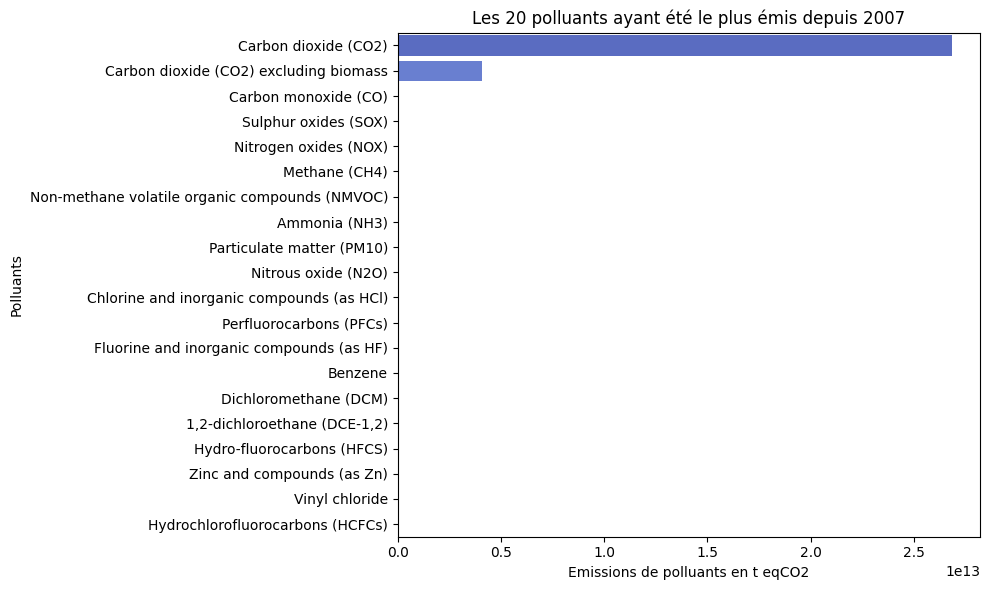

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(data=group_by_pollutant.head(20), x=group_by_pollutant["sum"].head(20), y=group_by_pollutant.index[:20], palette="coolwarm")
plt.title("Les 20 polluants ayant été le plus émis depuis 2007")
plt.xlabel("Emissions de polluants en t eqCO2")
plt.ylabel("Polluants")
plt.tight_layout()
plt.show()

Comparer la quantité totale émise de chacun de ces polluants ne nous fournit pas d'informations utiles, à l'exception du fait que le CO2 est le gaz le plus largement rejeté dans l'atmosphère depuis 2007.

L'idéal, serait de regarder l'évolution de l'émission de polluants au fil des années ou sinon, de corréler ce dataset avec des données comme le Potentiel de Réchauffement Global (PRG) afin d'étudier le degré de dangerosité de chacun de ces gaz à effet de serre (GES).

### GROUP BY YEAR

In [131]:
df.reportingYear.value_counts()

reportingYear
2007    23703
2008    23604
2010    22733
2009    22637
2011    22565
2012    22142
2013    22057
2014    21832
2015    21718
2017    21640
2016    21603
2018    21597
2019    20569
2020    17767
2021    16182
Name: count, dtype: int64

In [132]:
group_by_year = df.groupby(["reportingYear", "pollutant"])["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)
group_by_year

sum   
reportingYear pollutant                                               
2007          Carbon dioxide (CO2)                     2.204991e+12  \
2008          Carbon dioxide (CO2)                     2.137824e+12   
2010          Carbon dioxide (CO2)                     2.063704e+12   
2009          Carbon dioxide (CO2)                     1.969666e+12   
2011          Carbon dioxide (CO2)                     1.955836e+12   
...                                                             ...   
              PCDD + PCDF (dioxins + furans) (as Teq)  5.671344e-01   
2012          PCDD + PCDF (dioxins + furans) (as Teq)  4.512370e-01   
2017          Halogenated organic compounds (as AOX)   7.000000e-02   
2012          Brominated diphenylethers (PBDE)         1.800000e-02   
2011          Brominated diphenylethers (PBDE)         2.000000e-03   

                                                               mean   
reportingYear pollutant                                               
2007          Carbon dioxide (CO2)                     9.743661e+08  \
2008          Carbon dioxide (CO2)                     9.214760e+08   
2010          Carbon dioxide (CO2)                     8.830571e+08   
2009          Carbon dioxide (CO2)                     8.757963e+08   
2011          Carbon dioxide (CO2)                     8.488873e+08   
...                                                             ...   
              PCDD + PCDF (dioxins + furans) (as Teq)  2.455127e-03   
2012          PCDD + PCDF (dioxins + furans) (as Teq)  2.290543e-03   
2017          Halogenated organic compounds (as AOX)   7.000000e-02   
2012          Brominated diphenylethers (PBDE)         1.800000e-02   
2011          Brominated diphenylethers (PBDE)         2.000000e-03   

                                                             median  
reportingYear pollutant                                              
2007          Carbon dioxide (CO2)                     3.490000e+08  
2008          Carbon dioxide (CO2)                     3.410000e+08  
2010          Carbon dioxide (CO2)                     3.130000e+08  
2009          Carbon dioxide (CO2)                     3.230000e+08  
2011          Carbon dioxide (CO2)                     3.160000e+08  
...                                                             ...  
              PCDD + PCDF (dioxins + furans) (as Teq)  3.430000e-04  
2012          PCDD + PCDF (dioxins + furans) (as Teq)  3.150000e-04  
2017          Halogenated organic compounds (as AOX)   7.000000e-02  
2012          Brominated diphenylethers (PBDE)         1.800000e-02  
2011          Brominated diphenylethers (PBDE)         2.000000e-03  

[797 rows x 3 columns]

In [133]:
group_by_CO2 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("CO2")]
group_by_CH4 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("CH4")]
group_by_N2O = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("N2O")]
group_by_PFCs = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("PFCs")]
group_by_HFCS = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("HFCS")]
group_by_SF6 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("SF6")]

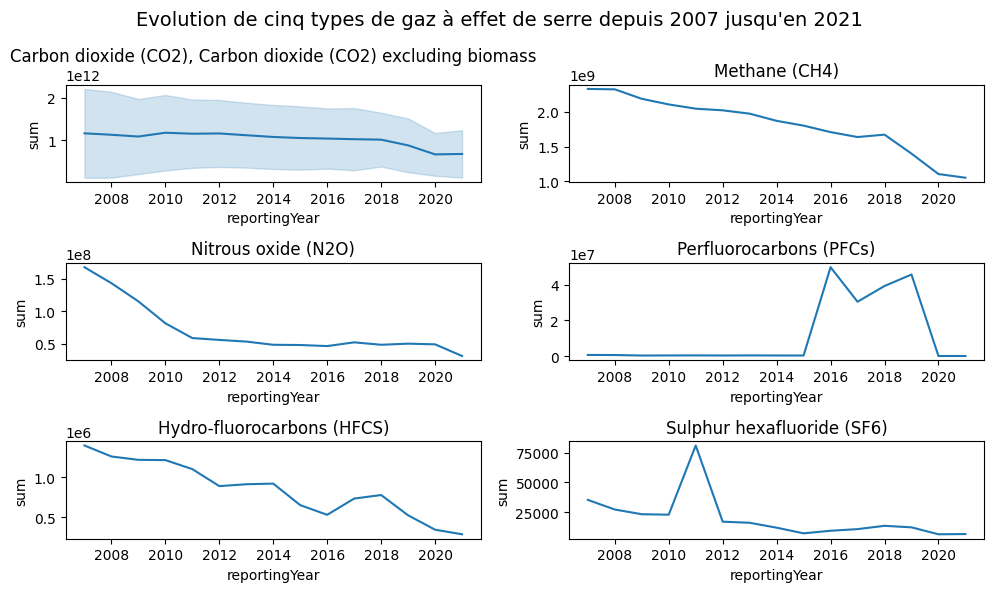

In [134]:
fig = plt.figure(1, figsize=(10, 6), tight_layout=True)

plt.suptitle("Evolution de cinq types de gaz à effet de serre depuis 2007 jusqu'en 2021", fontsize=14)

plt.subplot(321)
plt.title(", ".join(group_by_CO2.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_CO2,
    x=group_by_CO2.index.get_level_values("reportingYear"),
    y=group_by_CO2["sum"]
)

plt.subplot(322)
plt.title(", ".join(group_by_CH4.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_CH4,
    x=group_by_CH4.index.get_level_values("reportingYear"),
    y=group_by_CH4["sum"]
)

plt.subplot(323)
plt.title(", ".join(group_by_N2O.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_N2O,
    x=group_by_N2O.index.get_level_values("reportingYear"),
    y=group_by_N2O["sum"]
)

plt.subplot(324)
plt.title(", ".join(group_by_PFCs.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_PFCs,
    x=group_by_PFCs.index.get_level_values("reportingYear"),
    y=group_by_PFCs["sum"]
)

plt.subplot(325)
plt.title(", ".join(group_by_HFCS.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_HFCS,
    x=group_by_HFCS.index.get_level_values("reportingYear"),
    y=group_by_HFCS["sum"]
)

plt.subplot(326)
plt.title(", ".join(group_by_SF6.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_SF6,
    x=group_by_SF6.index.get_level_values("reportingYear"),
    y=group_by_SF6["sum"]
)

plt.show()

Nous avons étudié l'évolution de la quantité de cinq gaz à effet de serre les plus courants : le dioxyde de carbone (CO2), le méthane (CH4), l'oxyde nitreux (N2O), le tétrafluorure de carbone (CF4, PFC-14), le trifluorométhane (CHF3, HFC-23) et l'hexafluorure de soufre (SF6).

Les différents graphiques montrent une diminution globale de ces polluants.

### GROUP BY SECTOR

In [135]:
group_by_sector = df.groupby(["eprtrSectorName", "pollutant"])["emissions"].sum()
group_by_sector

eprtrSectorName                                                  pollutant                    
Animal and vegetable products from the food and beverage sector  Ammonia (NH3)                    1.267974e+07
                                                                 Arsenic and compounds (as As)    3.238000e+02
                                                                 Benzene                          5.705000e+04
                                                                 Cadmium and compounds (as Cd)    4.104000e+02
                                                                 Carbon dioxide (CO2)             1.223143e+11
                                                                                                      ...     
Waste and wastewater management                                  Trichloroethylene (TRI)          1.002520e+06
                                                                 Trichloromethane                 3.172400e+04
                 

In [136]:
group_confidential_by_sector = df_confidential.groupby(["eprtrSectorName", "pollutant"])["emissions"].sum()

In [137]:
group_confidential_by_sector

eprtrSectorName                                                  pollutant                       
Animal and vegetable products from the food and beverage sector  Ammonia (NH3)                       1.063000e+05
                                                                 Carbon dioxide (CO2)                3.763741e+09
                                                                 Chlorofluorocarbons (CFCs)          4.900000e+01
                                                                 Hydro-fluorocarbons (HFCS)          3.030700e+03
                                                                 Hydrochlorofluorocarbons (HCFCs)    3.980000e+02
                                                                                                         ...     
Waste and wastewater management                                  Chlorofluorocarbons (CFCs)          6.837480e+01
                                                                 Hydrochlorofluorocarbons (HCFCs)    9.0

### GROUP BY ACTIVITY

In [138]:
group_by_activity = df.groupby(["EPRTRAnnexIMainActivityLabel", "pollutant"])["emissions"].sum()
group_by_activity

EPRTRAnnexIMainActivityLabel                                                                                                                                                                                                                                    pollutant                    
Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.  1,2-dichloroethane (DCE-1,2)     7.740000e+03
                                                                                                                                                                                                                                                                Ammonia (NH3)                    6.035183e+07
                                                                                                              

In [139]:
group_by_business = df.groupby(["EPRTRAnnexIMainActivityLabel", "pollutant"])["emissions"].sum()
group_by_business

EPRTRAnnexIMainActivityLabel                                                                                                                                                                                                                                    pollutant                    
Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.  1,2-dichloroethane (DCE-1,2)     7.740000e+03
                                                                                                                                                                                                                                                                Ammonia (NH3)                    6.035183e+07
                                                                                                              

In [140]:
df

countryName   
0              Austria  \
1              Austria   
2              Austria   
3              Austria   
4              Austria   
...                ...   
324550  United Kingdom   
324551  United Kingdom   
324552  United Kingdom   
324553  United Kingdom   
324554  United Kingdom   

                                                        eprtrSectorName   
0                                                     Chemical industry  \
1                                                      Other activities   
2                              Paper and wood production and processing   
3                              Paper and wood production and processing   
4                                                      Mineral industry   
...                                                                 ...   
324550  Animal and vegetable products from the food and beverage sector   
324551                                  Waste and wastewater management   
324552                                  Waste and wastewater management   
324553                   Intensive livestock production and aquaculture   
324554                   Intensive livestock production and aquaculture   

                                                                                                                                                                                                                                                                       EPRTRAnnexIMainActivityLabel   
0                                                                                                                                                                                   Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
1                                                                           Installations for the surface treatment of substances, objects or products using organic solvents, in particular for dressing, printing, coating, degreasing, waterproofing, sizing, painting, cleaning or impregnating   
2                                                                                                                                                               Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
3                                                                                                                                                               Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
4       Installations for the production of cement clinker in rotary kilns, lime in rotary kilns, cement or lime in other furnaces. Note to reporters, use Level 3 activity e.g. 3(c)(i), in preference to 3(c). Level 2 activity class (i.e. 3(c)) only to be used where Level 3 is not available.   
...                                                                                                                                                                                                                                                                                             ...   
324550                                                                                                                                                                              Treatment and processing intended for the production of food and beverage products from vegetable raw materials   
324551                                                                                                 Installations for the incineration of non-hazardous waste in the scope of Directive 2000/76/EC of the European Parliament and of the Council of 4 December 2000 on the incineration of waste   
324552                                                                                                 Installations for the incineration of n

### MOST REPRESENTATIVE POLLUTANTS GROUPED BY SECTOR

In [141]:
companies_group_by_sector = df.groupby("eprtrSectorName")["FacilityInspireID"].nunique()

companies_group_by_sector

eprtrSectorName
Animal and vegetable products from the food and beverage sector      981
Chemical industry                                                   1543
Energy sector                                                       2532
Intensive livestock production and aquaculture                     14122
Mineral industry                                                    1919
Other activities                                                     807
Paper and wood production and processing                             509
Production and processing of metals                                 1538
Waste and wastewater management                                     3186
Name: FacilityInspireID, dtype: int64

In [142]:
pollutants_group_by_sector = df.groupby("eprtrSectorName")["pollutant"]

In [143]:
pollutants_group_by_sector.describe()

count unique   
eprtrSectorName                                                                 
Animal and vegetable products from the food and beverage sector   6648     30  \
Chemical industry                                                24180     56   
Energy sector                                                    80219     53   
Intensive livestock production and aquaculture                   93464     14   
Mineral industry                                                 35261     40   
Other activities                                                  5428     48   
Paper and wood production and processing                         13235     39   
Production and processing of metals                              27677     53   
Waste and wastewater management                                  36237     59   

                                                                                                            top   
eprtrSectorName                                                                                                   
Animal and vegetable products from the food and beverage sector                      Hydro-fluorocarbons (HFCS)  \
Chemical industry                                                Non-methane volatile organic compounds (NMVOC)   
Energy sector                                                                             Nitrogen oxides (NOX)   
Intensive livestock production and aquaculture                                                    Ammonia (NH3)   
Mineral industry                                                                          Nitrogen oxides (NOX)   
Other activities                                                 Non-methane volatile organic compounds (NMVOC)   
Paper and wood production and processing                                                  Nitrogen oxides (NOX)   
Production and processing of metals                                                  Zinc and compounds (as Zn)   
Waste and wastewater management                                                                   Methane (CH4)   

                                                                  freq  
eprtrSectorName                                                         
Animal and vegetable products from the food and beverage sector   1183  
Chemical industry                                                 3008  
Energy sector                                                    15976  
Intensive livestock production and aquaculture                   89513  
Mineral industry                                                  8187  
Other activities                                                  3576  
Paper and wood production and processing                          3039  
Production and processing of metals                               3103  
Waste and wastewater management                                  14889

In [144]:
emissions_of_pollutants_group_by_sector = df.groupby(["eprtrSectorName", "pollutant"])
emissions_of_pollutants_group_by_sector["emissions"].describe()

count   
eprtrSectorName                                                 pollutant                              
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                  356.0  \
                                                                Arsenic and compounds (as As)    5.0   
                                                                Benzene                         34.0   
                                                                Cadmium and compounds (as Cd)   14.0   
                                                                Carbon dioxide (CO2)           664.0   
...                                                                                              ...   
Waste and wastewater management                                 Trichloroethylene (TRI)         13.0   
                                                                Trichloromethane                25.0   
                                                                Vinyl chloride                  17.0   
                                                                Xylenes                          1.0   
                                                                Zinc and compounds (as Zn)     328.0   

                                                                                                       mean   
eprtrSectorName                                                 pollutant                                     
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                  3.561726e+04  \
                                                                Arsenic and compounds (as As)  6.476000e+01   
                                                                Benzene                        1.677941e+03   
                                                                Cadmium and compounds (as Cd)  2.931429e+01   
                                                                Carbon dioxide (CO2)           1.842083e+08   
...                                                                                                     ...   
Waste and wastewater management                                 Trichloroethylene (TRI)        7.711692e+04   
                                                                Trichloromethane               1.268960e+03   
                                                                Vinyl chloride                 3.085859e+04   
                                                                Xylenes                        6.040000e+03   
                                                                Zinc and compounds (as Zn)     6.822347e+02   

                                                                                                        std   
eprtrSectorName                                                 pollutant                                     
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                  3.186598e+04  \
                                                                Arsenic and compounds (as As)  5.183462e+01   
                                                                Benzene                        5.821214e+02   
                                                                Cadmium and compounds (as Cd)  2.019184e+01   
                                                                Carbon dioxide (CO2)           1.434349e+08   
...                                                                                                     ...   
Waste and wastewater management                                 Trichloroethylene (TRI)        7.982327e+04   
                                                                Trichloromethane               1.029192e+03   
                                                                Vinyl chloride                 3.447619e+04   
                                                                Xylenes      

In [145]:
pollutant_group_by_sector = df.groupby(["reportingYear", "eprtrSectorName", "pollutant"])["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)

In [146]:
pollutant_group_by_sector

sum   
reportingYear eprtrSectorName                                                 pollutant                                               
2007          Energy sector                                                   Carbon dioxide (CO2)                     1.561867e+12  \
2008          Energy sector                                                   Carbon dioxide (CO2)                     1.508504e+12   
2010          Energy sector                                                   Carbon dioxide (CO2)                     1.476674e+12   
2009          Energy sector                                                   Carbon dioxide (CO2)                     1.446421e+12   
2011          Energy sector                                                   Carbon dioxide (CO2)                     1.371601e+12   
...                                                                                                                             ...   
2016          Animal and vegetable products from the food and beverage sector PCDD + PCDF (dioxins + furans) (as Teq)  2.400000e-04   
              Chemical industry                                               Toluene                                  2.000000e-04   
2019          Other activities                                                PCDD + PCDF (dioxins + furans) (as Teq)  1.280000e-04   
2021          Waste and wastewater management                                 Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   
2020          Waste and wastewater management                                 Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   

                                                                                                                               mean   
reportingYear eprtrSectorName                                                 pollutant                                               
2007          Energy sector                                                   Carbon dioxide (CO2)                     1.400778e+09  \
2008          Energy sector                                                   Carbon dioxide (CO2)                     1.329078e+09   
2010          Energy sector                                                   Carbon dioxide (CO2)                     1.284064e+09   
2009          Energy sector                                                   Carbon dioxide (CO2)                     1.283426e+09   
2011          Energy sector                                                   Carbon dioxide (CO2)                     1.252604e+09   
...                                                                                                                             ...   
2016          Animal and vegetable products from the food and beverage sector PCDD + PCDF (dioxins + furans) (as Teq)  2.400000e-04   
              Chemical industry                                               Toluene                                  2.000000e-04   
2019          Other activities                                                PCDD + PCDF (dioxins + furans) (as Teq)  1.280000e-04   
2021          Waste and wastewater management                                 Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   
2020          Waste and wastewater management                                 Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   

                                                                                                                             median  
reportingYear eprtrSectorName                                                 pollutant                                              
2007          Energy sector                                                   Carbon dioxide (CO2)                     5.310000e+08  
2008          Energy sector                                                   Carbon dioxide (CO2)                     5.190000e+08  
2010          Energy sector                                                   Ca

In [147]:
co2_data = pollutant_group_by_sector[pollutant_group_by_sector.index.get_level_values("pollutant") == "Carbon dioxide (CO2)"]
co2_data

sum   
reportingYear eprtrSectorName                                pollutant                            
2007          Energy sector                                  Carbon dioxide (CO2)  1.561867e+12  \
2008          Energy sector                                  Carbon dioxide (CO2)  1.508504e+12   
2010          Energy sector                                  Carbon dioxide (CO2)  1.476674e+12   
2009          Energy sector                                  Carbon dioxide (CO2)  1.446421e+12   
2011          Energy sector                                  Carbon dioxide (CO2)  1.371601e+12   
...                                                                                         ...   
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  6.910000e+08   
2018          Other activities                               Carbon dioxide (CO2)  6.721656e+08   
2009          Other activities                               Carbon dioxide (CO2)  6.045000e+08   
2010          Other activities                               Carbon dioxide (CO2)  6.026000e+08   
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  1.720000e+08   

                                                                                           mean   
reportingYear eprtrSectorName                                pollutant                            
2007          Energy sector                                  Carbon dioxide (CO2)  1.400778e+09  \
2008          Energy sector                                  Carbon dioxide (CO2)  1.329078e+09   
2010          Energy sector                                  Carbon dioxide (CO2)  1.284064e+09   
2009          Energy sector                                  Carbon dioxide (CO2)  1.283426e+09   
2011          Energy sector                                  Carbon dioxide (CO2)  1.252604e+09   
...                                                                                         ...   
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  6.910000e+08   
2018          Other activities                               Carbon dioxide (CO2)  9.602365e+07   
2009          Other activities                               Carbon dioxide (CO2)  1.209000e+08   
2010          Other activities                               Carbon dioxide (CO2)  1.506500e+08   
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  1.720000e+08   

                                                                                        median  
reportingYear eprtrSectorName                                pollutant                          
2007          Energy sector                                  Carbon dioxide (CO2)  531000000.0  
2008          Energy sector                                  Carbon dioxide (CO2)  519000000.0  
2010          Energy sector                                  Carbon dioxide (CO2)  447000000.0  
2009          Energy sector                                  Carbon dioxide (CO2)  474000000.0  
2011          Energy sector                                  Carbon dioxide (CO2)  468000000.0  
...                                                                                        ...  
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  691000000.0  
2018          Other activities                               Carbon dioxide (CO2)   25800000.0  
2009          Other activities                               Carbon dioxide (CO2)  117000000.0  
2010          Other activities                               Carbon dioxide (CO2)  159000000.0  
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  172000000.0  

[125 rows x 3 columns]

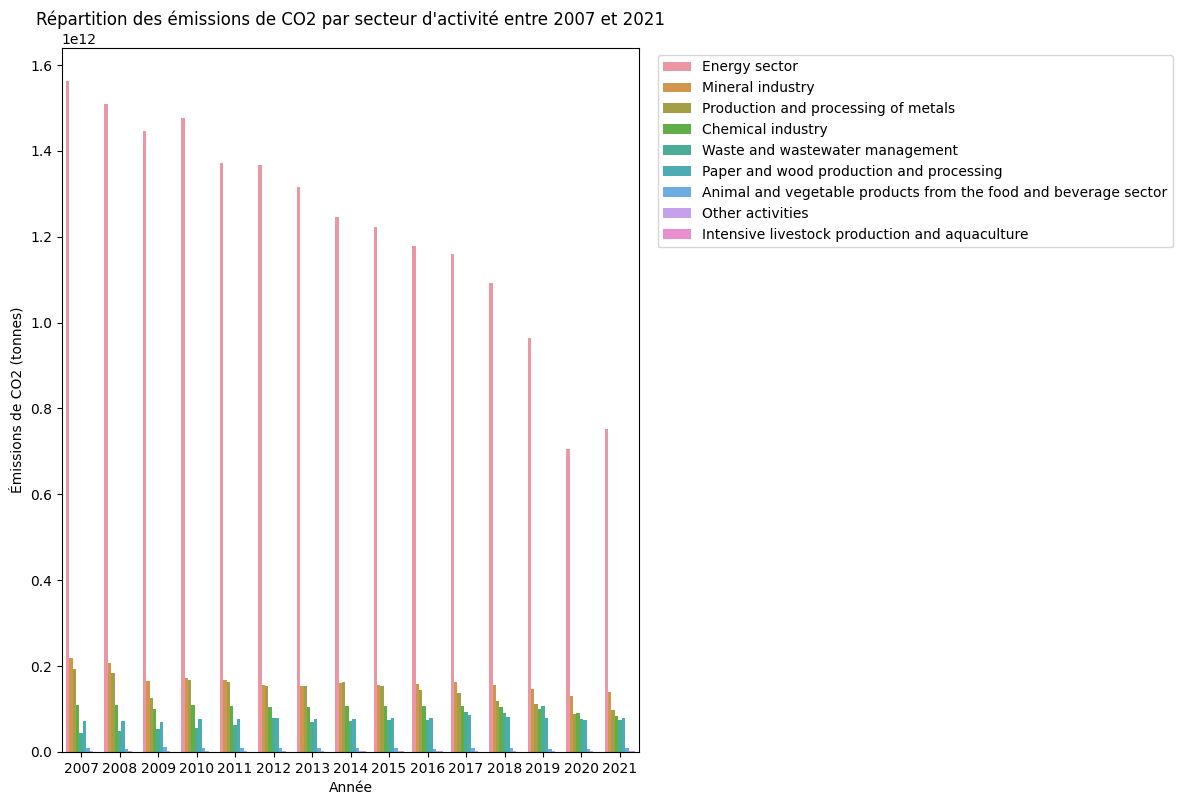

In [148]:
co2_data = co2_data.reset_index()

plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="sum", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (tonnes)")
plt.title("Répartition des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

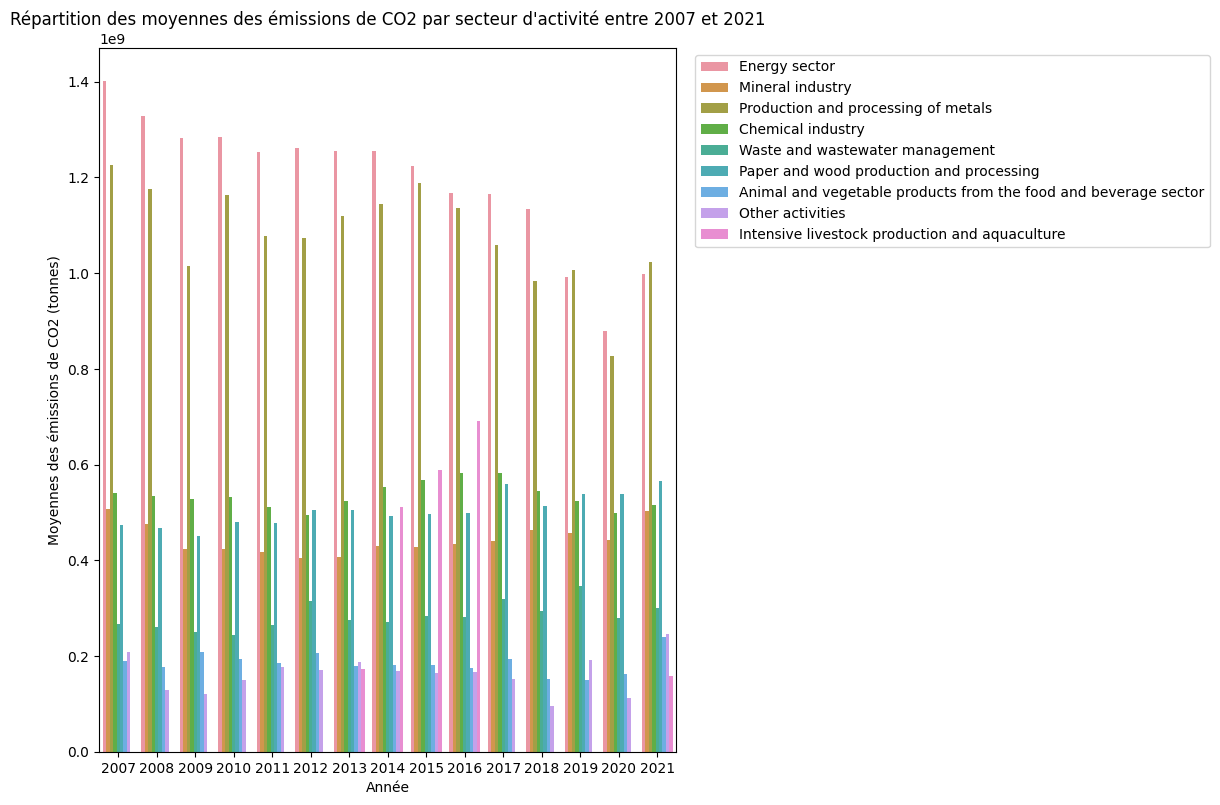

In [149]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="mean", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Moyennes des émissions de CO2 (tonnes)")
plt.title("Répartition des moyennes des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

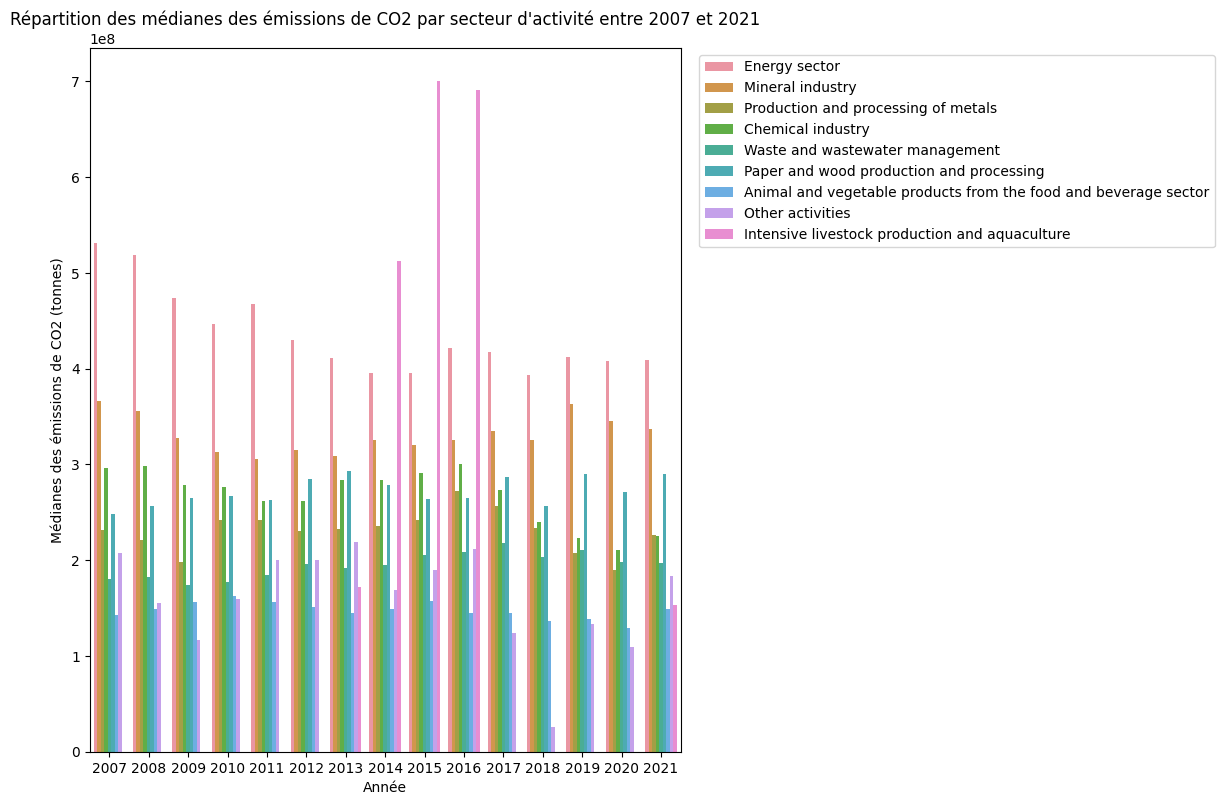

In [150]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="median", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Médianes des émissions de CO2 (tonnes)")
plt.title("Répartition des médianes des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

La médiane du secteur Intensive livestock production and aquaculture en ce qui concerne les émissions de CO2 est aussi élevée car il n'y a que 13 entrées basées sur ce polluant dans ce secteur.

In [151]:
emissions_of_pollutants_group_by_sector = emissions_of_pollutants_group_by_sector["emissions"].aggregate(
    ["count", "sum", "median", "mean"])
emissions_of_pollutants_group_by_sector

count   
eprtrSectorName                                                 pollutant                              
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                    356  \
                                                                Arsenic and compounds (as As)      5   
                                                                Benzene                           34   
                                                                Cadmium and compounds (as Cd)     14   
                                                                Carbon dioxide (CO2)             664   
...                                                                                              ...   
Waste and wastewater management                                 Trichloroethylene (TRI)           13   
                                                                Trichloromethane                  25   
                                                                Vinyl chloride                    17   
                                                                Xylenes                            1   
                                                                Zinc and compounds (as Zn)       328   

                                                                                                        sum   
eprtrSectorName                                                 pollutant                                     
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                  1.267974e+07  \
                                                                Arsenic and compounds (as As)  3.238000e+02   
                                                                Benzene                        5.705000e+04   
                                                                Cadmium and compounds (as Cd)  4.104000e+02   
                                                                Carbon dioxide (CO2)           1.223143e+11   
...                                                                                                     ...   
Waste and wastewater management                                 Trichloroethylene (TRI)        1.002520e+06   
                                                                Trichloromethane               3.172400e+04   
                                                                Vinyl chloride                 5.245960e+05   
                                                                Xylenes                        6.040000e+03   
                                                                Zinc and compounds (as Zn)     2.237730e+05   

                                                                                                    median   
eprtrSectorName                                                 pollutant                                    
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                      23050.0  \
                                                                Arsenic and compounds (as As)         31.6   
                                                                Benzene                             1545.0   
                                                                Cadmium and compounds (as Cd)         21.3   
                                                                Carbon dioxide (CO2)           147000000.0   
...                                                                                                    ...   
Waste and wastewater management                                 Trichloroethylene (TRI)            53000.0   
                                                                Trichloromethane                     800.0   
                                                                Vinyl chloride                     13600.0   
                                                                Xylenes                 

In [152]:
emissions_of_pollutants_group_by_sector = emissions_of_pollutants_group_by_sector[
    emissions_of_pollutants_group_by_sector.index.get_level_values("pollutant") != "CONFIDENTIAL"]

In [153]:
print("Nombre d'enregistrement total :", emissions_of_pollutants_group_by_sector["count"].sum())
print("Nombre de polluant total :", len(df.pollutant.unique()))

Nombre d'enregistrement total : 322349
Nombre de polluant total : 67


In [154]:
count_pollutant_over36 = emissions_of_pollutants_group_by_sector[emissions_of_pollutants_group_by_sector["count"] >= 36]
print("Nombre d'enregistrement restant :", count_pollutant_over36["count"].sum())
print("Nombre de polluant restant :", len(
    count_pollutant_over36\
    .groupby("pollutant")[["count", "sum"]]\
    .sum()\
    .sort_values(by=["count"])
))

Nombre d'enregistrement restant : 320869
Nombre de polluant restant : 50


In [155]:
emissions_of_pollutants_group_by_sector.groupby("eprtrSectorName")[["count", "sum"]].sum()

count   
eprtrSectorName                                                          
Animal and vegetable products from the food and beverage sector   6648  \
Chemical industry                                                24180   
Energy sector                                                    80219   
Intensive livestock production and aquaculture                   93464   
Mineral industry                                                 35261   
Other activities                                                  5428   
Paper and wood production and processing                         13235   
Production and processing of metals                              27677   
Waste and wastewater management                                  36237   

                                                                          sum  
eprtrSectorName                                                                
Animal and vegetable products from the food and beverage sector  1.368210e+11  
Chemical industry                                                1.760630e+12  
Energy sector                                                    2.147534e+13  
Intensive livestock production and aquaculture                   7.929384e+09  
Mineral industry                                                 2.795853e+12  
Other activities                                                 1.698097e+10  
Paper and wood production and processing                         1.228366e+12  
Production and processing of metals                              2.465563e+12  
Waste and wastewater management                                  1.204387e+12

In [156]:
count_pollutant_over36.groupby("eprtrSectorName")[["count", "sum"]].sum()

count   
eprtrSectorName                                                          
Animal and vegetable products from the food and beverage sector   6449  \
Chemical industry                                                24026   
Energy sector                                                    79917   
Intensive livestock production and aquaculture                   93409   
Mineral industry                                                 35209   
Other activities                                                  5177   
Paper and wood production and processing                         13126   
Production and processing of metals                              27576   
Waste and wastewater management                                  35980   

                                                                          sum  
eprtrSectorName                                                                
Animal and vegetable products from the food and beverage sector  1.368208e+11  
Chemical industry                                                1.760630e+12  
Energy sector                                                    2.147533e+13  
Intensive livestock production and aquaculture                   3.324315e+09  
Mineral industry                                                 2.795853e+12  
Other activities                                                 1.632250e+10  
Paper and wood production and processing                         1.228366e+12  
Production and processing of metals                              2.465563e+12  
Waste and wastewater management                                  1.204385e+12

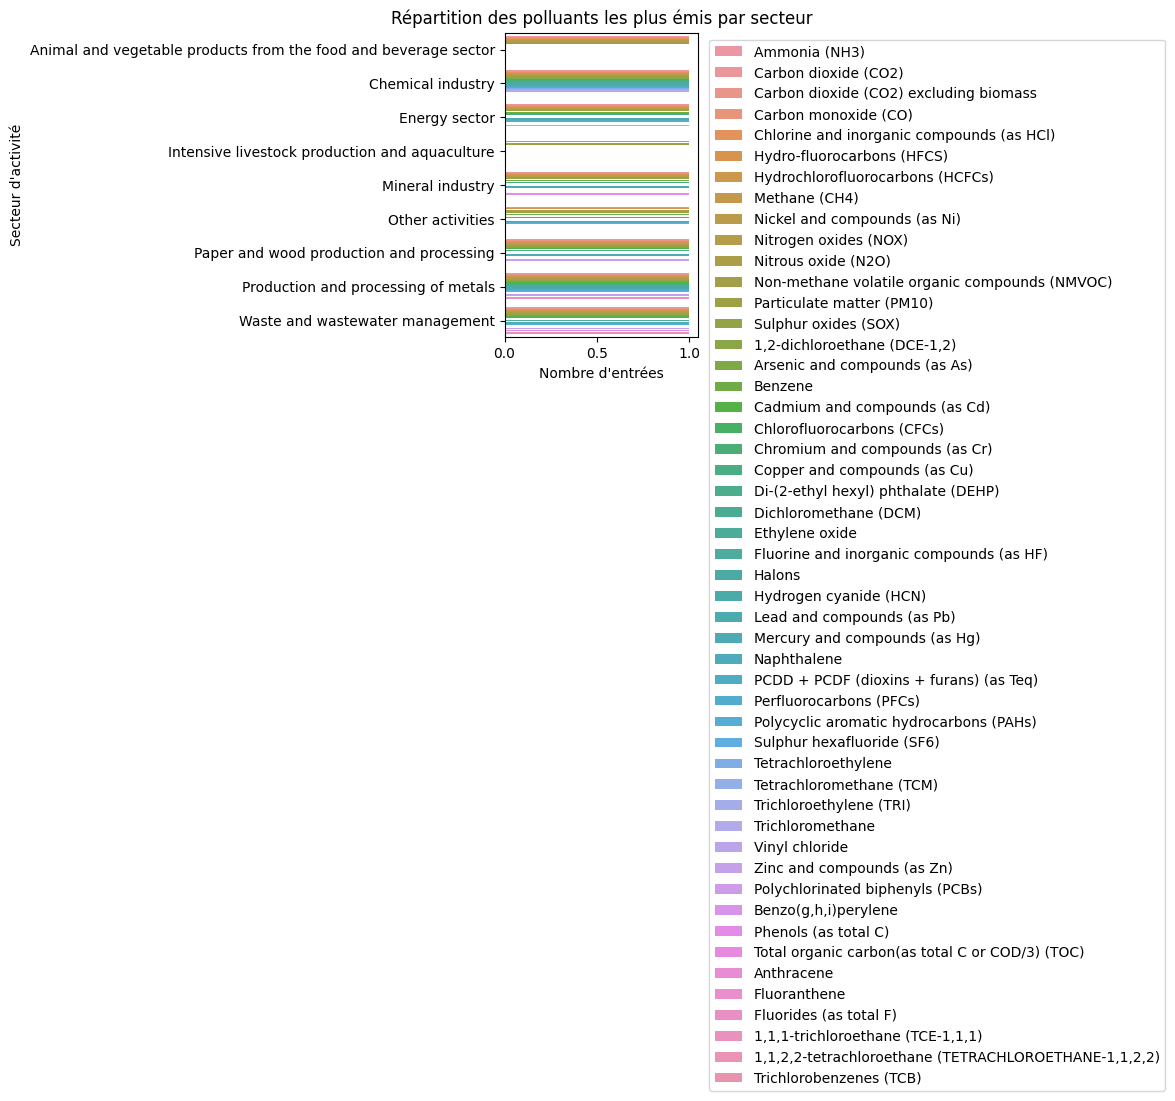

In [157]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.countplot(
    data=count_pollutant_over36, 
    y=count_pollutant_over36.index.get_level_values("eprtrSectorName"),
    hue=count_pollutant_over36.index.get_level_values("pollutant"),
)
plt.xlabel("Nombre d'entrées")
plt.ylabel("Secteur d'activité")
plt.title("Répartition des polluants les plus émis par secteur")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [158]:
count_pollutant_over36

count   
eprtrSectorName                                                 pollutant                                                
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                                      356  \
                                                                Carbon dioxide (CO2)                               664   
                                                                Carbon dioxide (CO2) excluding biomass              96   
                                                                Carbon monoxide (CO)                               197   
                                                                Chlorine and inorganic compounds (as HCl)          135   
...                                                                                                                ...   
Waste and wastewater management                                 Polycyclic aromatic hydrocarbons (PAHs)             43   
                                                                Sulphur oxides (SOX)                               291   
                                                                Total organic carbon(as total C or COD/3) (TOC)    156   
                                                                Trichlorobenzenes (TCB)                             72   
                                                                Zinc and compounds (as Zn)                         328   

                                                                                                                          sum   
eprtrSectorName                                                 pollutant                                                       
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                                    1.267974e+07  \
                                                                Carbon dioxide (CO2)                             1.223143e+11   
                                                                Carbon dioxide (CO2) excluding biomass           1.357212e+10   
                                                                Carbon monoxide (CO)                             1.850331e+08   
                                                                Chlorine and inorganic compounds (as HCl)        2.096854e+06   
...                                                                                                                       ...   
Waste and wastewater management                                 Polycyclic aromatic hydrocarbons (PAHs)          2.825845e+04   
                                                                Sulphur oxides (SOX)                             1.406134e+08   
                                                                Total organic carbon(as total C or COD/3) (TOC)  1.152943e+05   
                                                                Trichlorobenzenes (TCB)                          2.303600e+03   
                                                                Zinc and compounds (as Zn)                       2.237730e+05   

                                                                                                                      median   
eprtrSectorName                                                 pollutant                                                      
Animal and vegetable products from the food and beverage sector Ammonia (NH3)                                        23050.0  \
                                                                Carbon dioxide (CO2)                             147000000.0   
                                                                Carbon dioxide (CO2) excluding biomass           124000000.0   
                                                                Carbon monoxide (CO)                                675000.0   
                                                                Chlorine and ino

/tmp/ipykernel_3609/3887985918.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



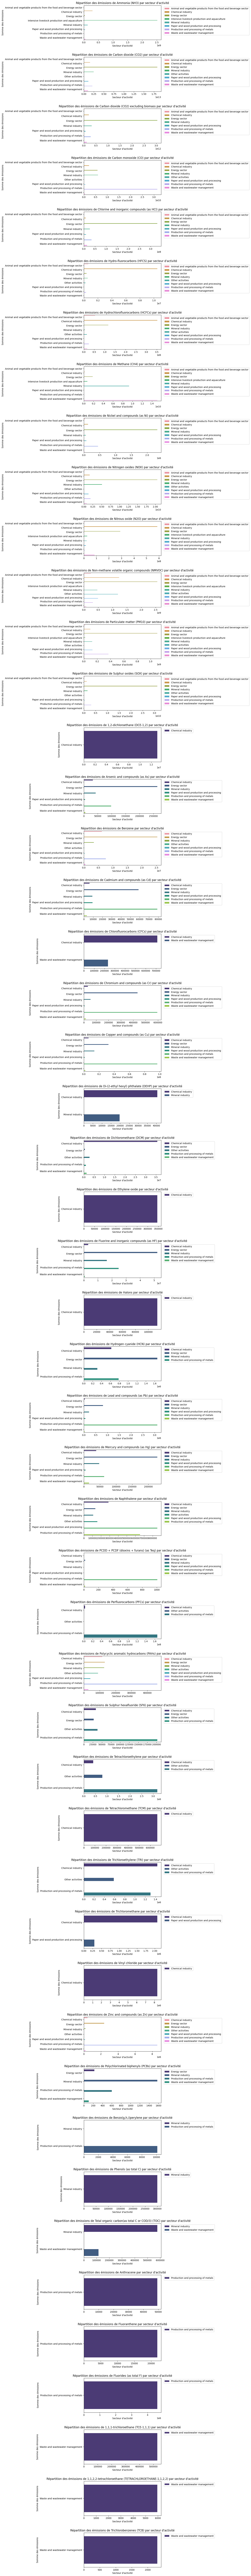

In [159]:
pollutants = count_pollutant_over36.index.get_level_values("pollutant").unique()

num_pollutants = len(pollutants)
fig, axes = plt.subplots(num_pollutants, 1, figsize=(6, num_pollutants*4), facecolor='white')

plt.subplots_adjust(hspace=0.5)

for i, pollutant in enumerate(pollutants):
    data = count_pollutant_over36[count_pollutant_over36.index.get_level_values("pollutant") == pollutant]

    ax = axes[i]
    sns.barplot(
        data=data.reset_index(),
        x="sum",
        y="eprtrSectorName",
        hue="eprtrSectorName",
        ax=ax
    )
    ax.set_xlabel("Secteur d'activité")
    ax.set_ylabel("Somme des émissions")
    ax.set_title(f"Répartition des émissions de {pollutant} par secteur d'activité")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

plt.show()

## Data processing

In [160]:
len(df)

322349

In [161]:
df = df[df.pollutant != "CONFIDENTIAL"]
len(df)

322349

In [162]:
df = df.merge(count_pollutant_over36, left_on=["eprtrSectorName", "pollutant"], right_index=True, how="inner")
df.head()

countryName    eprtrSectorName   
0       Austria  Chemical industry  \
220     Austria  Chemical industry   
436     Austria  Chemical industry   
641     Austria  Chemical industry   
852     Austria  Chemical industry   

                                                                                        EPRTRAnnexIMainActivityLabel   
0    Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
220  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
436  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
641  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
852  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   

                  FacilityInspireID  City                     pollutant   
0    AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)  \
220  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
436  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
641  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
852  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   

     emissions  reportingYear  count         sum  median         mean  
0       3300.0           2007    328  13083822.0  8675.0  39889.70122  
220     3310.0           2008    328  13083822.0  8675.0  39889.70122  
436     2550.0           2009    328  13083822.0  8675.0  39889.70122  
641     3220.0           2010    328  13083822.0  8675.0  39889.70122  
852     2820.0           2011    328  13083822.0  8675.0  39889.70122

In [163]:
len(df.pollutant.unique())

50

In [164]:
df.pollutant.unique()

array(['1,2-dichloroethane (DCE-1,2)',
       'Non-methane volatile organic compounds (NMVOC)',
       'Carbon dioxide (CO2)', 'Nitrogen oxides (NOX)',
       'Sulphur oxides (SOX)', 'Zinc and compounds (as Zn)',
       'Carbon monoxide (CO)', 'Methane (CH4)',
       'Mercury and compounds (as Hg)', 'Hydrogen cyanide (HCN)',
       'Particulate matter (PM10)', 'Nitrous oxide (N2O)',
       'Hydrochlorofluorocarbons (HCFCs)',
       'Chromium and compounds (as Cr)', 'Copper and compounds (as Cu)',
       'Lead and compounds (as Pb)',
       'Chlorine and inorganic compounds (as HCl)', 'Ammonia (NH3)',
       'Benzene', 'Polycyclic aromatic hydrocarbons (PAHs)',
       'Dichloromethane (DCM)', 'Cadmium and compounds (as Cd)',
       'Nickel and compounds (as Ni)',
       'PCDD + PCDF (dioxins + furans) (as Teq)',
       'Hydro-fluorocarbons (HFCS)',
       'Fluorine and inorganic compounds (as HF)', 'Naphthalene',
       'Arsenic and compounds (as As)', 'Sulphur hexafluoride (SF6)',
    

In [165]:
df.pollutant.value_counts()

pollutant
Ammonia (NH3)                                            95983
Nitrogen oxides (NOX)                                    37007
Carbon dioxide (CO2)                                     32386
Methane (CH4)                                            22827
Sulphur oxides (SOX)                                     17114
Non-methane volatile organic compounds (NMVOC)           12926
Nitrous oxide (N2O)                                       8799
Carbon monoxide (CO)                                      8068
Particulate matter (PM10)                                 7343
Hydrochlorofluorocarbons (HCFCs)                          6563
Mercury and compounds (as Hg)                             6559
Zinc and compounds (as Zn)                                6144
Carbon dioxide (CO2) excluding biomass                    5990
Chlorine and inorganic compounds (as HCl)                 5939
Nickel and compounds (as Ni)                              5636
Hydro-fluorocarbons (HFCS)                   

In [166]:
group_by_sector_pollutant = df.groupby(["eprtrSectorName", "pollutant"])["emissions"]\
    .quantile(q=[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.99])

In [167]:
group_by_sector_pollutant = group_by_sector_pollutant.unstack().stack().reset_index()
group_by_sector_pollutant = group_by_sector_pollutant.rename(columns={"level_2": "category", 0: "thresholdCategory"})
group_by_sector_pollutant.head(8)

eprtrSectorName   
0  Animal and vegetable products from the food and beverage sector  \
1  Animal and vegetable products from the food and beverage sector   
2  Animal and vegetable products from the food and beverage sector   
3  Animal and vegetable products from the food and beverage sector   
4  Animal and vegetable products from the food and beverage sector   
5  Animal and vegetable products from the food and beverage sector   
6  Animal and vegetable products from the food and beverage sector   
7  Animal and vegetable products from the food and beverage sector   

       pollutant  category  thresholdCategory  
0  Ammonia (NH3)     0.125            12000.0  
1  Ammonia (NH3)     0.250            14500.0  
2  Ammonia (NH3)     0.375            17912.5  
3  Ammonia (NH3)     0.500            23050.0  
4  Ammonia (NH3)     0.625            34500.0  
5  Ammonia (NH3)     0.750            49825.0  
6  Ammonia (NH3)     0.875            61987.5  
7  Ammonia (NH3)     0.990           162700.0

In [168]:
df[
    (df.eprtrSectorName == "Animal and vegetable products from the food and beverage sector") &
    (df.pollutant == "Carbon dioxide (CO2)") &
    (df.emissions > 6.585500e+08)
]["emissions"].describe()

count    7.000000e+00
mean     1.100714e+09
std      3.138422e+08
min      7.760000e+08
25%      9.625000e+08
50%      9.940000e+08
75%      1.125000e+09
max      1.760000e+09
Name: emissions, dtype: float64

In [169]:
def get_category(sector: str, pollutant: str, emission: float, return_col: str, last_elem: int = -1) -> float:
    subset = group_by_sector_pollutant[
        (group_by_sector_pollutant.eprtrSectorName == sector) &
        (group_by_sector_pollutant.pollutant == pollutant) &
        (group_by_sector_pollutant.thresholdCategory < emission)
    ][return_col] 

    return subset.iloc[last_elem] if len(subset) > 0 else 0.0

In [170]:
df["category"] = df.apply(
    lambda x: get_category(
        x["eprtrSectorName"], 
        x["pollutant"], 
        x["emissions"], 
        "category"
    ),
    axis=1
)

In [171]:
df.head()

countryName    eprtrSectorName   
0       Austria  Chemical industry  \
220     Austria  Chemical industry   
436     Austria  Chemical industry   
641     Austria  Chemical industry   
852     Austria  Chemical industry   

                                                                                        EPRTRAnnexIMainActivityLabel   
0    Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
220  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
436  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
641  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
852  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   

                  FacilityInspireID  City                     pollutant   
0    AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)  \
220  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
436  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
641  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
852  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   

     emissions  reportingYear  count         sum  median         mean   
0       3300.0           2007    328  13083822.0  8675.0  39889.70122  \
220     3310.0           2008    328  13083822.0  8675.0  39889.70122   
436     2550.0           2009    328  13083822.0  8675.0  39889.70122   
641     3220.0           2010    328  13083822.0  8675.0  39889.70122   
852     2820.0           2011    328  13083822.0  8675.0  39889.70122   

     category  
0       0.250  
220     0.250  
436     0.125  
641     0.250  
852     0.125

TODO
- Voir activité si même référentiel
- Voir doublon, etc.... Est-ce utile ?

- PRG ?

- Analyser le polluant Total Organic Carbon (TOC) : https://en.wikipedia.org/wiki/Total_organic_carbon

In [172]:
df[df.pollutant == "Hydro-fluorocarbons (HFCS)"]["emissions"].describe()

count      4698.000000
mean       2718.744443
std       18467.071373
min           0.000000
25%         168.000000
50%         318.500000
75%         884.500000
max      419000.000000
Name: emissions, dtype: float64

In [173]:
df[(df.pollutant == "Hydro-fluorocarbons (HFCS)") & (df.emissions > 100_000)]

countryName    eprtrSectorName   
2894       Belgium  Chemical industry  \
3716       Belgium  Chemical industry   
4527       Belgium  Chemical industry   
5238       Belgium  Chemical industry   
5975       Belgium  Chemical industry   
6747       Belgium  Chemical industry   
10559      Belgium  Chemical industry   
11089      Belgium  Chemical industry   
45735       France  Chemical industry   
45982       France  Chemical industry   
55981       France  Chemical industry   
58694       France  Chemical industry   
61412       France  Chemical industry   
63940       France  Chemical industry   
66283       France  Chemical industry   
80958      Germany  Chemical industry   
83748      Germany  Chemical industry   
86648      Germany  Chemical industry   
89546      Germany  Chemical industry   
92496      Germany  Chemical industry   
98423      Germany  Chemical industry   
101322     Germany  Chemical industry   
109614     Germany  Chemical industry   
112237     Germany  Chemical industry   
240411       Spain  Chemical industry   

                                                                                                                                                                                                                                          EPRTRAnnexIMainActivityLabel   
2894    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.  \
3716    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.   
4527    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.   
5238    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.   
5975    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.   
6747    Chemical installations for the production on an industrial scale of basic organic chemicals. Note to reporters, use Level 3 activity e.g. 4(a)(iii), in preference to 4(a). Level 2 activity class (i.e. 4(a)) only to be used where Level 3 is not available.   
10559                            Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins   
11089                            Chemical installations for the production on an industrial scale of basic organic chemicals: Oxygen-containing hydrocarbons such as alcohols, aldehydes, ketones, carboxylic acids, esters, acetates, ethers, peroxides, epoxy resins   
45735                                                                                                                                              Chemical installations for the production on an industrial scale of basic organic chemicals: Halogenic hydrocarbons   
45982                                                                                                                                                   Chemical installations for the production on an industrial scale of basic organic chemicals: Synthetic rubbers   
55981         

## GWP

### Create feature

In [174]:
df["gwpEmissions"] = df.apply(lambda x: x["emissions"] * settings.GWP[x["pollutant"]], axis=1)

### Dataviz

In [175]:
df_gwp_over_0 = df[df.gwpEmissions > 0]
df_gwp_over_0["gwpEmissions"].describe()

count    7.898500e+04
mean     4.263065e+08
std      3.293787e+09
min      3.110000e-03
25%      5.625000e+06
50%      6.400000e+07
75%      2.900000e+08
max      4.978314e+11
Name: gwpEmissions, dtype: float64

In [176]:
gwp_group_by_pollutant = df_gwp_over_0.groupby("pollutant")["emissions"]\
    .agg(["count", "sum", "min", "median", "mean", "max"])\
    .sort_values(by="sum", ascending=False)
gwp_group_by_pollutant

count           sum        min   
pollutant                                                                
Carbon dioxide (CO2)                    32380  2.685548e+13  232.93100  \
Carbon dioxide (CO2) excluding biomass   5921  4.073891e+12    0.00311   
Methane (CH4)                           22819  2.723299e+10    1.91100   
Nitrous oxide (N2O)                      8799  1.043473e+09    0.01410   
Perfluorocarbons (PFCs)                   529  1.690088e+08  103.00000   
Hydro-fluorocarbons (HFCS)               4697  1.277266e+07    1.50000   
Chlorofluorocarbons (CFCs)               3418  9.475361e+05    0.01000   
Sulphur hexafluoride (SF6)                422  3.004938e+05    1.00000   

                                             median          mean   
pollutant                                                           
Carbon dioxide (CO2)                    309547330.0  8.293847e+08  \
Carbon dioxide (CO2) excluding biomass  179000000.0  6.880410e+08   
Methane (CH4)                              347000.0  1.193435e+06   
Nitrous oxide (N2O)                         24300.0  1.185900e+05   
Perfluorocarbons (PFCs)                      3050.0  3.194874e+05   
Hydro-fluorocarbons (HFCS)                    319.0  2.719323e+03   
Chlorofluorocarbons (CFCs)                     20.2  2.772195e+02   
Sulphur hexafluoride (SF6)                    205.0  7.120705e+02   

                                                 max  
pollutant                                             
Carbon dioxide (CO2)                    4.320000e+10  
Carbon dioxide (CO2) excluding biomass  3.220000e+10  
Methane (CH4)                           1.450000e+08  
Nitrous oxide (N2O)                     2.760000e+07  
Perfluorocarbons (PFCs)                 4.930000e+07  
Hydro-fluorocarbons (HFCS)              4.190000e+05  
Chlorofluorocarbons (CFCs)              8.740000e+04  
Sulphur hexafluoride (SF6)              6.210000e+04

In [177]:
gwp_group_by_pollutant_and_sector = df_gwp_over_0.groupby(["eprtrSectorName", "pollutant"])["emissions"]\
    .agg(["count", "sum", "min", "median", "mean", "max"])
gwp_group_by_pollutant_and_sector.head()

count   
eprtrSectorName                                                 pollutant                                       
Animal and vegetable products from the food and beverage sector Carbon dioxide (CO2)                      664  \
                                                                Carbon dioxide (CO2) excluding biomass     95   
                                                                Hydro-fluorocarbons (HFCS)               1183   
                                                                Methane (CH4)                              55   
                                                                Nitrous oxide (N2O)                       114   

                                                                                                                 sum   
eprtrSectorName                                                 pollutant                                              
Animal and vegetable products from the food and beverage sector Carbon dioxide (CO2)                    1.223143e+11  \
                                                                Carbon dioxide (CO2) excluding biomass  1.357212e+10   
                                                                Hydro-fluorocarbons (HFCS)              6.247929e+05   
                                                                Methane (CH4)                           2.871610e+07   
                                                                Nitrous oxide (N2O)                     4.397500e+06   

                                                                                                            min   
eprtrSectorName                                                 pollutant                                         
Animal and vegetable products from the food and beverage sector Carbon dioxide (CO2)                    52520.0  \
                                                                Carbon dioxide (CO2) excluding biomass  45614.0   
                                                                Hydro-fluorocarbons (HFCS)                  1.5   
                                                                Methane (CH4)                             160.0   
                                                                Nitrous oxide (N2O)                     10100.0   

                                                                                                             median   
eprtrSectorName                                                 pollutant                                             
Animal and vegetable products from the food and beverage sector Carbon dioxide (CO2)                    147000000.0  \
                                                                Carbon dioxide (CO2) excluding biomass  125000000.0   
                                                                Hydro-fluorocarbons (HFCS)                    260.0   
                                                                Methane (CH4)                              170000.0   
                                                                Nitrous oxide (N2O)                         20400.0   

                                                                                                                mean   
eprtrSectorName                                                 pollutant                                              
Animal and vegetable products from the food and beverage sector Carbon dioxide (CO2)                    1.842083e+08  \
                                                                Carbon dioxide (CO2) excluding biomass  1.428644e+08   
                                                                Hydro-fluorocarbons (HFCS)              5.281428e+02   
                                                                Methane (CH4)                           5.221110e+05   
                                                                Nitrous oxide (N2O)                     3.85745

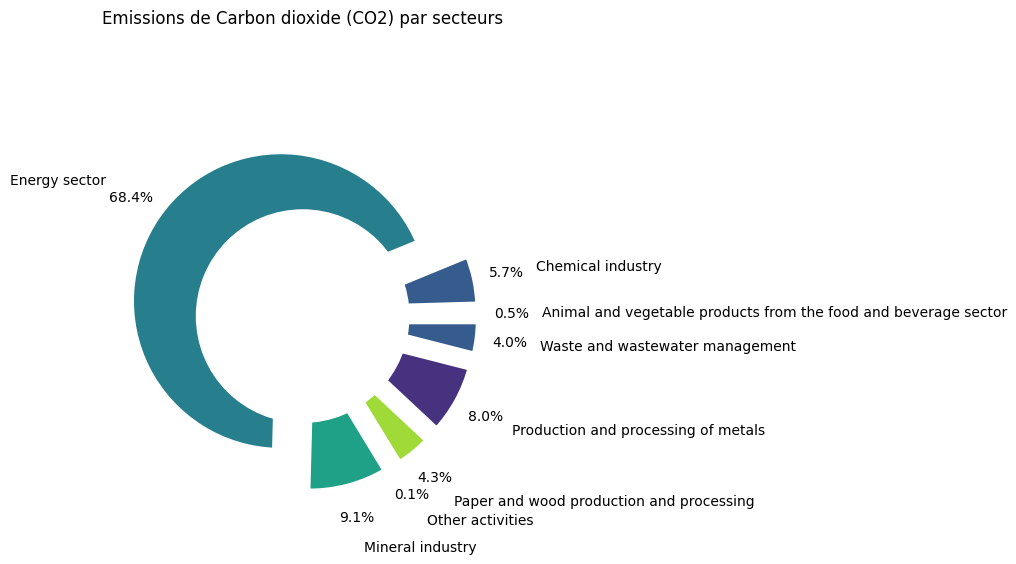

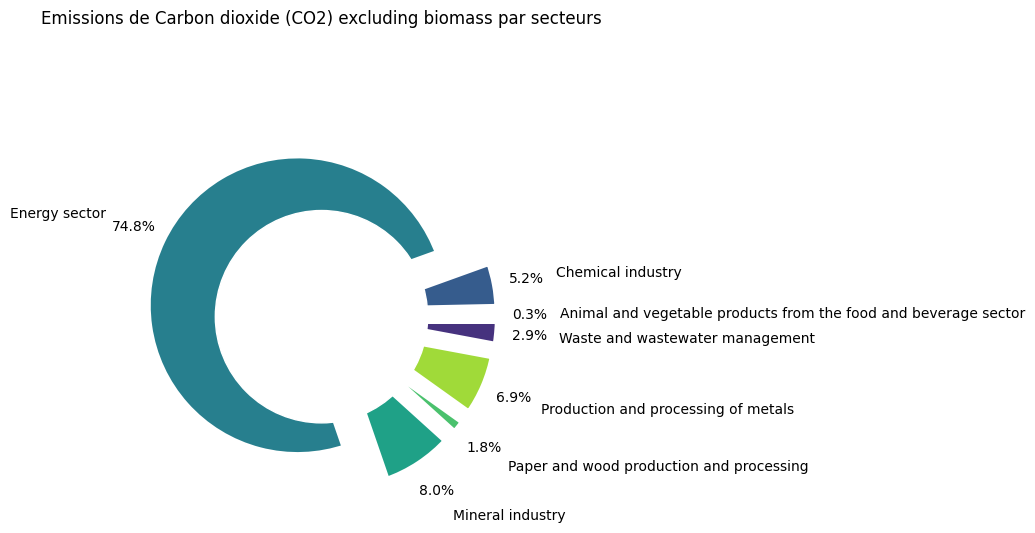

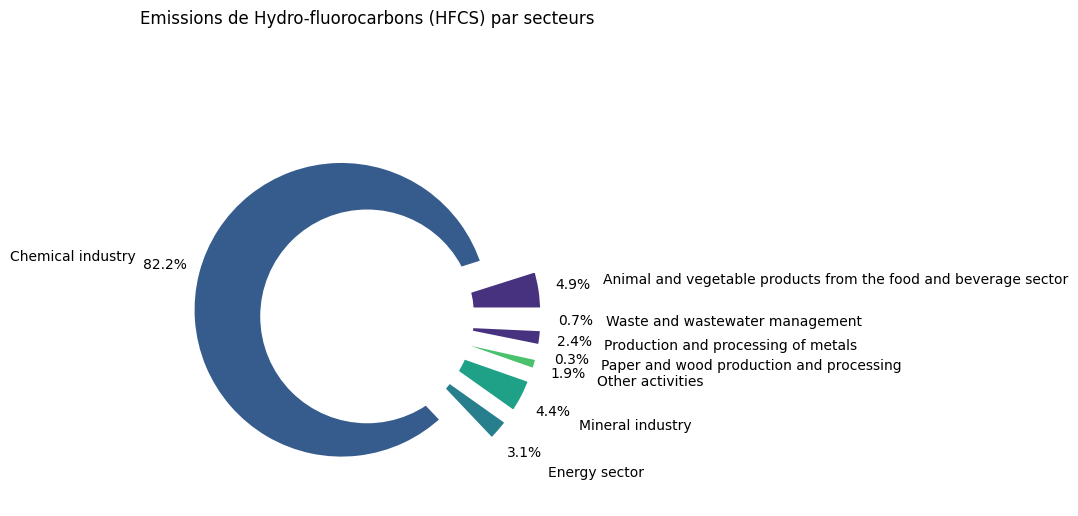

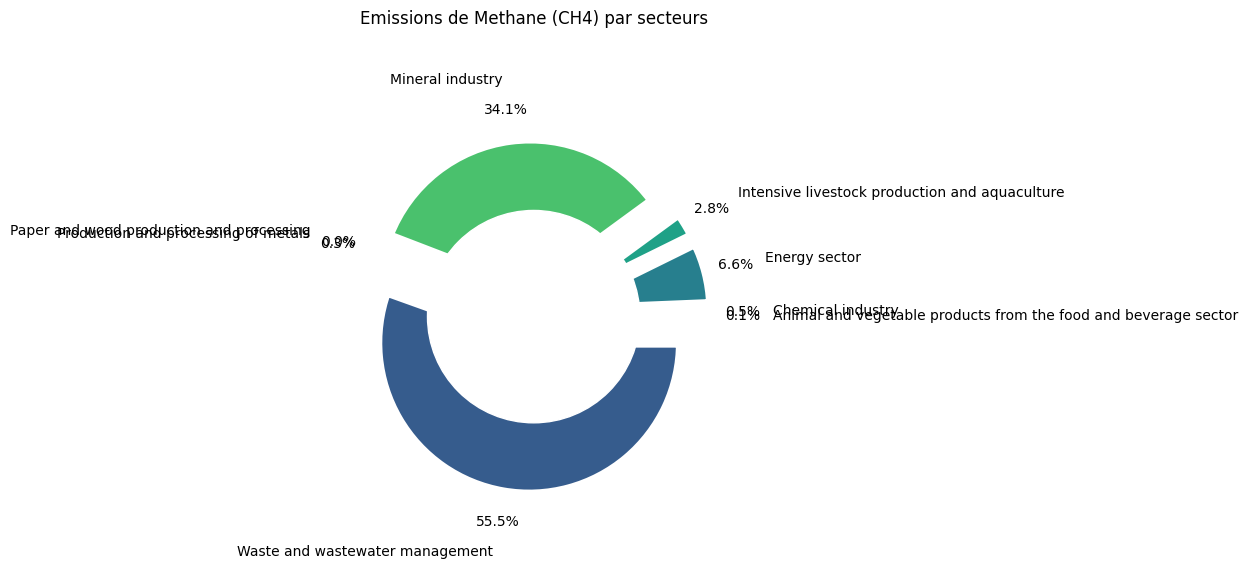

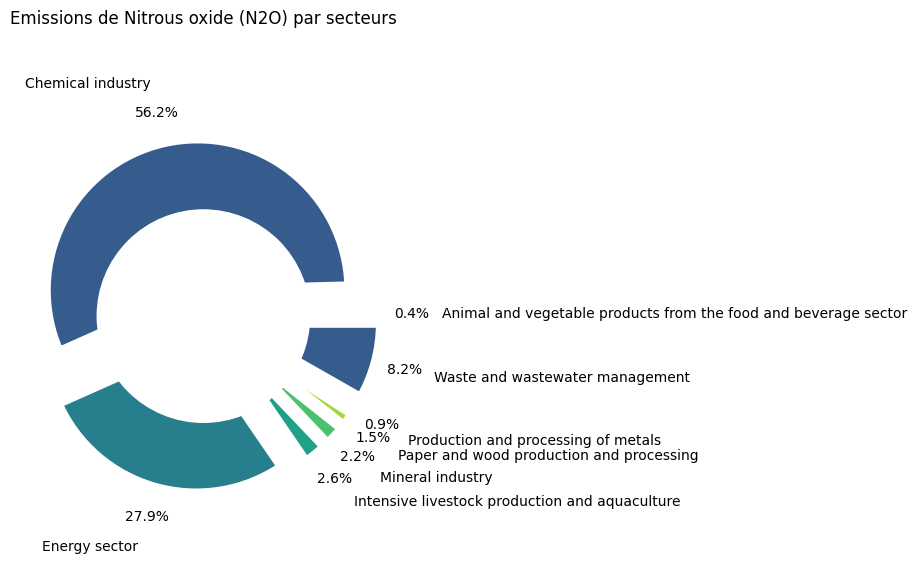

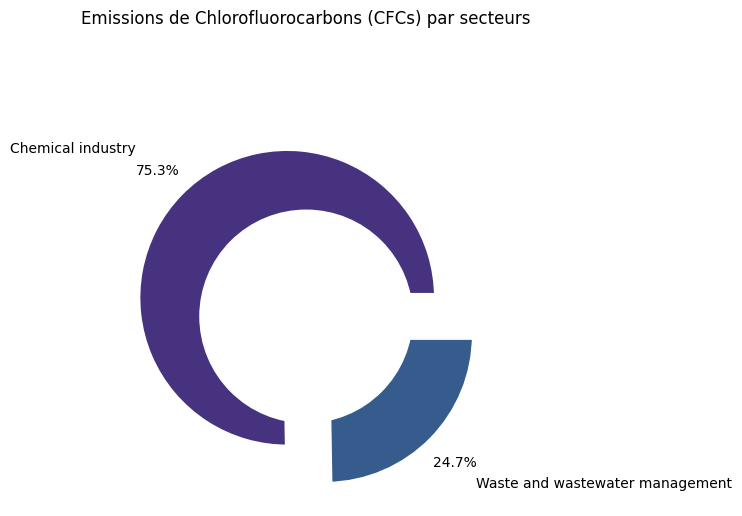

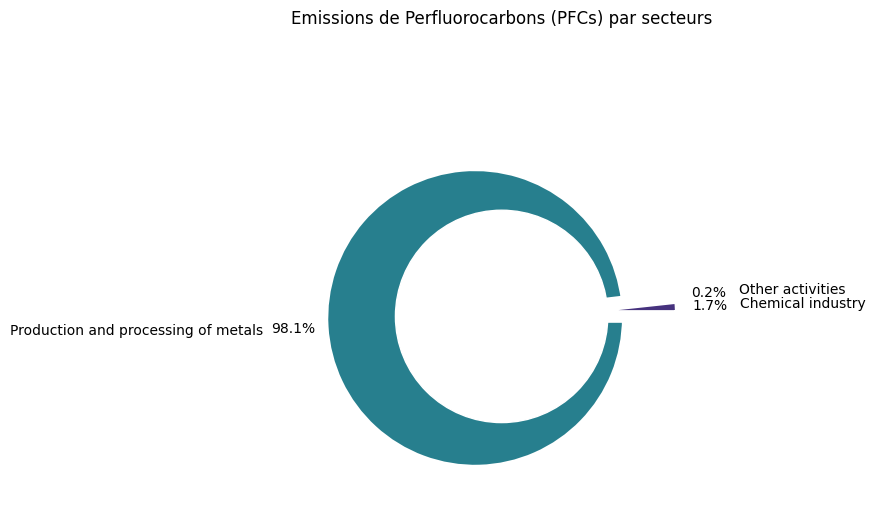

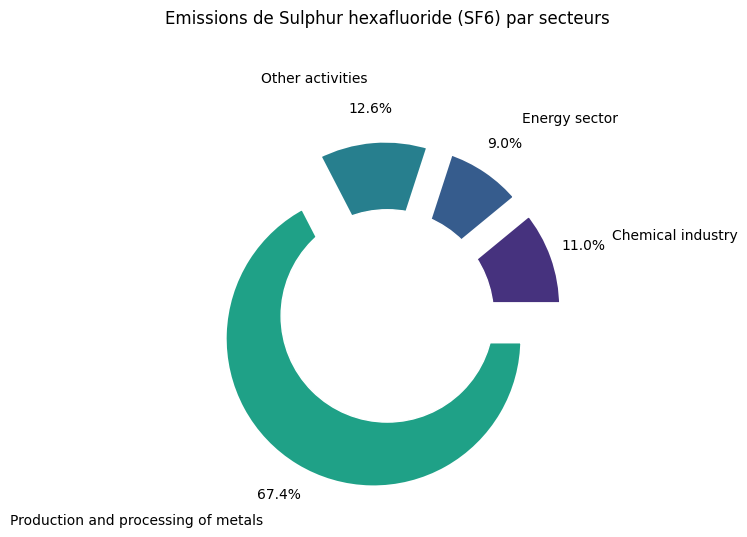

In [178]:
for index, pollutant in enumerate(gwp_group_by_pollutant_and_sector.index.get_level_values("pollutant").unique()):
    filter_pollutant = gwp_group_by_pollutant_and_sector[
        (gwp_group_by_pollutant_and_sector.index.get_level_values("pollutant") == pollutant)
    ]

    names = filter_pollutant.index.get_level_values("eprtrSectorName").unique()
    size = filter_pollutant["sum"]

    center_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(
        size,
        labels=names,
        wedgeprops={ 'linewidth' : 7, 'edgecolor' : 'white' },
        autopct='%1.1f%%',
        pctdistance=1.2,
        labeldistance=1.4,
        explode=[0.175] * len(names)
    )

    plt.title(f"Emissions de {pollutant} par secteurs",  y=1.25)

    p = plt.gcf()
    p.gca().add_artist(center_circle)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [179]:
df.head()

countryName    eprtrSectorName   
0       Austria  Chemical industry  \
220     Austria  Chemical industry   
436     Austria  Chemical industry   
641     Austria  Chemical industry   
852     Austria  Chemical industry   

                                                                                        EPRTRAnnexIMainActivityLabel   
0    Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
220  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
436  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
641  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   
852  Chemical installations for the production on an industrial scale of basic plant health products and of biocides   

                  FacilityInspireID  City                     pollutant   
0    AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)  \
220  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
436  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
641  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   
852  AT.CAED/9008390392737.FACILITY  Linz  1,2-dichloroethane (DCE-1,2)   

     emissions  reportingYear  count         sum  median         mean   
0       3300.0           2007    328  13083822.0  8675.0  39889.70122  \
220     3310.0           2008    328  13083822.0  8675.0  39889.70122   
436     2550.0           2009    328  13083822.0  8675.0  39889.70122   
641     3220.0           2010    328  13083822.0  8675.0  39889.70122   
852     2820.0           2011    328  13083822.0  8675.0  39889.70122   

     category  gwpEmissions  
0       0.250           0.0  
220     0.250           0.0  
436     0.125           0.0  
641     0.250           0.0  
852     0.125           0.0

- Detection d'anomalies dans la data, prévenir des pannes d'outils, monitoring de la data.
- Faut-il normaliser les données ?
- Qu'est-ce que les insights indiquent ?
- Depuis quand pollue-t-il ? 
- Mesurer l'impact global ?
- Toutes les entreprises d'un même secteur utilisent-elles les mêmes polluants ?
- Comment mesurer l'importance d'un polluant ?
- Cas 1 :
 le banquier va entrer chaque émission d'un polluant de l'entreprise cible, qui reçoit donc une note pour chacun de ces polluants, le tout servant à une notation globale. 2 algos de ML =>
 - un prenant en entrée un polluant (3 colonnes : polluant, medium, quantité), et on entraine le modèle avec catégorisation et scaling.
  - Le 2ème modèle prendrait en entrée un secteur ou une activité et la note de tous les polluants relatifs, et en output on obtient une note globale.
Avantage = on peut évaluer pour une entreprise TOUS les polluants (peu importe le medium).
Inconvénient = fiabilité de l'algo ? solution => on pourrait regarder si les entreprises avec une énorme quantité de polluants émis sont correctement flagged (cohérence du flag par rapport à la quantité de polluant émis)
- Cas 2 :
 On entraine notre seul model avec comme données d'entraînement le secteur et une feature par polluant (CO2, Azote, etc)
Inconvénient : bcp de dimensions (surtout en comptant tous les média)
- Mise en concurrence des deux algos ?
- Régression linéaire ? Biais car chaque polluant a un impact différent (et tous ne sont pas convertibles en équivalent tonnes CO2), donc notation non objective et biaisée de part la quantité et non l'impact réel.
- Voir les algos pertinents (entre arbre de décisions, forêts aléatoires, etc). Possibilité de labellisation via un autre algo de ML afin d'utiliser ces algos (SVM avec notre dataset labellisé par exemple).